## Header

In [ ]:
import sys

sys.path.append(
    "/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/analysis_scripts/"
)

from scipy.io import loadmat
from scipy.stats import bootstrap
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy import fft
import scipy
import traceback
import pandas as pd
import numpy as np
import h5py
import pickle
import oceans_sf as ocsf
import collections
from calculate_spectral_fluxes import SpectralFlux
from calculate_sfs import StructureFunctions
from flux_sf_figures import *
import flux_sf_figures
import swot_analysis as swotan
from matplotlib import pyplot as plt
import time
import xarray as xr
import cartopy.crs as ccrs
import glob

import seaborn as sns

sns.set_style(style="white")
sns.set_context("talk")

plt.rcParams["figure.figsize"] = [9, 6]
# plt.rcParams['figure.dpi'] = 100
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
# %config InlineBackend.figure_format = 'svg'

import os

os.environ["PATH"] = os.environ["PATH"] + ":/Library/TeX/texbin"
import matplotlib as mpl

mpl.rcParams["text.usetex"] = True
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True

from geopy import distance as gd

import warnings

warnings.filterwarnings("ignore")

from astropy import units as u
from astropy import constants as c

from datetime import datetime
import re

: 

## Reload external modules

In [2]:
import importlib
# import sys
if 'flux_sf_figures' not in sys.modules:
    import flux_sf_figures            # import module on first run 
else:                      
    import flux_sf_figures      
    importlib.reload(flux_sf_figures)

if 'oceans_sf' not in sys.modules:
    import oceans_sf as ocsf            # import module on first run 
else:                      
    import oceans_sf as ocsf     
    importlib.reload(ocsf)

if 'cg_funcs' not in sys.modules:
    import cg_funcs            # import module on first run 
else:                      
    import cg_funcs      
    importlib.reload(cg_funcs)

In [3]:
def PostProcess(sfs,dict=True,trad=False,scalar=False):
    mean_SF_velocity_meridional,mean_SF_velocity_zonal = flux_sf_figures.SFMean(sfs,dict,trad,scalar)
    xdiffs = flux_sf_figures.SeperationDifferences(sfs,dict,trad,scalar)
    SF_velocity_zonals,SF_velocity_meridionals = flux_sf_figures.ReformatSF(sfs,dict,trad,scalar)
    boot_SF_vz, boot_SF_vm = flux_sf_figures.BootstrapSF(SF_velocity_zonals,SF_velocity_meridionals,SF_3rd_velocity_zonals=None,SF_3rd_velocity_meridionals=None,trad=trad,scalar=scalar)
    return(mean_SF_velocity_zonal,mean_SF_velocity_meridional,xdiffs,boot_SF_vz,boot_SF_vm)

## Load data

In [4]:
filepath = '/Users/cassswagner/Library/CloudStorage/Box-Box/2D_Data_For_Cassidy/Aniso*.mat'
filename_test = '/Users/cassswagner/Library/CloudStorage/Box-Box/2D_Data_For_Cassidy/Anisotropic2D_n_2048_drag_0.04_order_-2_visc_1.0e-21_order_8_kf_100.0_F_1.0e-5_betay_10.0_betax_0.0_3000.mat'

In [5]:
f = h5py.File(filename_test, "r")

x = np.linspace(-f['Lx'][0]/2,f['Lx'][0]/2,f['nx'][0])
y = np.linspace(-f['Ly'][0]/2,f['Ly'][0]/2,f['ny'][0])

In [407]:
filenames = [filename for filename in glob.glob(filepath) if float(re.search('betay_(.+?)_betax', filename).group(1)) == 10.0]

In [408]:
appended_data = []

for file in glob.glob(filepath):
    f = h5py.File(file, 'r')
    
    betay = float(re.search('betay_(.+?)_betax', filename_test).group(1))

    if betay == 10.0:

        # betax = float(re.search('betax_(.+?)_', filename_test).group(1))
        timestep = float(re.search('_0.0_(.+?).mat', filename_test).group(1))

        x = np.linspace(-f['Lx'][0],f['Lx'][0],f['nx'][0])
        y = np.linspace(-f['Ly'][0],f['Ly'][0],f['ny'][0])
        start = time.time()
        sfs_v = ocsf.advection_velocity(f['u'], f['v'], x, y)
        end = time.time()
        print('finished %s at %s' %(timestep, end-start))
        # sfs_sc = ocsf.advection_scalar(f['b'], f['u'], f['v'], x, y)
        
        df = pd.DataFrame({'SF_velocity': sfs_v, 'beta_y': betay, 't': timestep})

        appended_data.append(df)
    else:
        pass

KeyboardInterrupt: 

In [ ]:
for i in range(243):

    file = glob.glob(filepath)[i]
    f = h5py.File(file, 'r')
    betay = float(re.search('betay_(.+?)_betax', file).group(1))
    timestep = float(re.search('betax_0.0_(.+?).mat', file).group(1))

    appended_data[i]['beta_y']['SF_isotropic'] = betay
    appended_data[i]['t']['SF_isotropic'] = timestep

    appended_data[i]['beta_y']['SF_meridional'] = betay
    appended_data[i]['t']['SF_meridional'] = timestep

    appended_data[i]['beta_y']['SF_zonal'] = betay
    appended_data[i]['t']['SF_zonal'] = timestep

    appended_data[i]['beta_y']['SF_zonal_uneven'] = betay
    appended_data[i]['t']['SF_zonal_uneven'] = timestep

    appended_data[i]['beta_y']['iso-diffs'] = betay
    appended_data[i]['t']['iso-diffs'] = timestep

    appended_data[i]['beta_y']['x-diffs'] = betay
    appended_data[i]['t']['x-diffs'] = timestep

    appended_data[i]['beta_y']['x-diffs_uneven'] = betay
    appended_data[i]['t']['x-diffs_uneven'] = timestep

    appended_data[i]['beta_y']['y-diffs'] = betay
    appended_data[i]['t']['y-diffs'] = timestep

    appended_data[i]['beta_y']['y-diffs_uneven'] = betay
    appended_data[i]['t']['y-diffs_uneven'] = timestep

In [ ]:
betay_10_data = [d for d in appended_data if d['beta_y']['SF_zonal'] == 10.0]
betay_10_data = [d.rename(columns={"SF_velocity": "SFv_adv", "beta_y": "beta_y", "t": "t"}) for d in betay_10_data]

betay_1_data = [d for d in appended_data if d['beta_y']['SF_zonal'] == 1.0]
betay_1_data = [d.rename(columns={"SF_velocity": "SFv_adv", "beta_y": "beta_y", "t": "t"}) for d in betay_1_data]

betay_0_data = [d for d in appended_data if d['beta_y']['SF_zonal'] == 0.0]
betay_0_data = [d.rename(columns={"SF_velocity": "SFv_adv", "beta_y": "beta_y", "t": "t"}) for d in betay_0_data]

In [ ]:
betay_10_post = PostProcess(betay_10_data,trad=False)

In [ ]:
SF_z_adv, SF_m_adv, xd, boot_SF_vz_adv, boot_SF_vm_adv = betay_10_post

boot_SF_vz_conf_adv = boot_SF_vz_adv.confidence_interval
boot_SF_vm_conf_adv = boot_SF_vm_adv.confidence_interval

boot_SF_vz_mean_adv = boot_SF_vz_adv.bootstrap_distribution.mean(axis=1)
boot_SF_vm_mean_adv = boot_SF_vm_adv.bootstrap_distribution.mean(axis=1)


fig, (ax1) = plt.subplots(figsize=(10, 7))

flux_sf_figures.SF_bootstrap_plot(
    (2 / 2) * boot_SF_vz_mean_adv,
    (2 / 2) * boot_SF_vm_mean_adv,
    xd,
    xd,
    bootz0=(2 / 2) * boot_SF_vz_conf_adv[0],
    bootz1=(2 / 2) * boot_SF_vz_conf_adv[1],
    bootm0=(2 / 2) * boot_SF_vm_conf_adv[0],
    bootm1=(2 / 2) * boot_SF_vm_conf_adv[1],
    title='Advection velocity dissipation rate',
    label1="Across-track",
    label2="Along-track",
    ax=ax1,
)

ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.set_ylim(-1e-5, 2.5e-5)
ax1.set_xlim(2e-3,1.4e0)
ax1.minorticks_on()
ax1.set_title('Advection velocity dissipation rate')

In [ ]:
f_adv_periodic = ocsf.advection_velocity(f['u'],f['v'],x,y,boundary='Periodic')

In [ ]:
f_vorticity_adv_periodic = ocsf.advection_scalar(f['zeta'],f['u'],f['v'],x,y,boundary='Periodic')

Text(0.5, 1.0, 'Advection velocity structure functions')

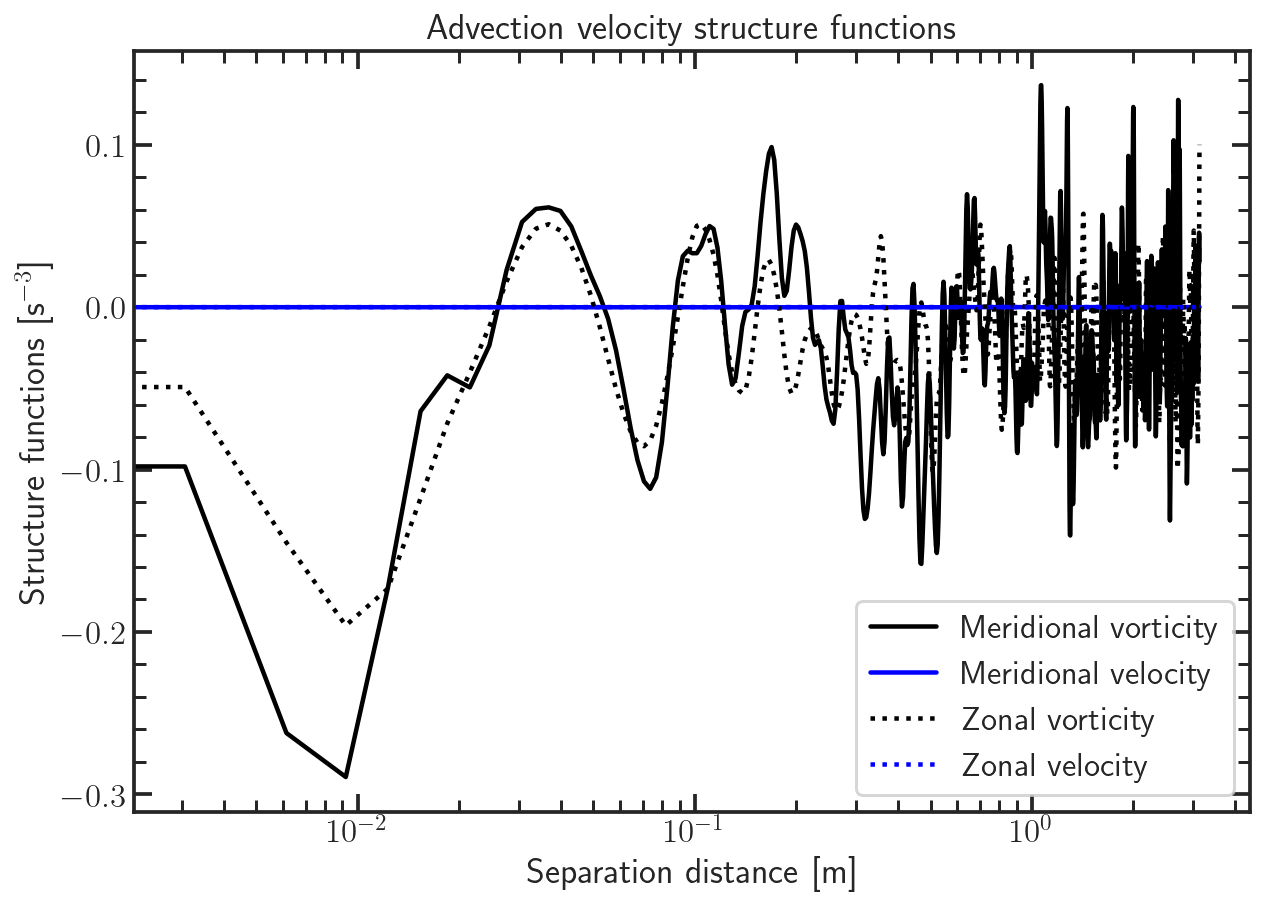

In [ ]:
fig, (ax1) = plt.subplots(figsize=(10, 7))

ax1.semilogx(
    f_vorticity_adv_periodic['x-diffs'], (f_vorticity_adv_periodic['SF_meridional']), color="k", label="Meridional vorticity")

ax1.semilogx(
    f_adv_periodic['x-diffs'], (f_adv_periodic['SF_meridional']), color="b", label="Meridional velocity")

ax1.semilogx(
    f_vorticity_adv_periodic['y-diffs'], (f_vorticity_adv_periodic['SF_zonal']), color="k", label="Zonal vorticity", linestyle='dotted')

ax1.semilogx(
    f_adv_periodic['y-diffs'], (f_adv_periodic['SF_zonal']), color="b", label="Zonal velocity", linestyle='dotted')
    
ax1.set_ylabel(r"Structure functions [s$^{-3}$]")
ax1.set_xlabel(r"Separation distance [m]")
ax1.legend()

ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_title('Advection velocity structure functions')



## Calculate spectral fluxes

In [6]:
def FFTFlux(u,v,x,Lx,dx):

    k_int = 1 / dx
    N = len(x)
    k = 2 * np.pi * (k_int / N) * np.linspace(-N / 2, N / 2 - 1, len(x))
    l = k
    kk, ll = np.meshgrid(k, l)

    # Calculate gradients exactly via spectral calculation
    dudx = np.real(fft.ifft2(fft.ifftshift(1j * kk * fft.fftshift(fft.fft2(u)))))
    dudy = np.real(fft.ifft2(fft.ifftshift(1j * ll * fft.fftshift(fft.fft2(u)))))
    dvdx = np.real(fft.ifft2(fft.ifftshift(1j * kk * fft.fftshift(fft.fft2(v)))))
    dvdy = np.real(fft.ifft2(fft.ifftshift(1j * ll * fft.fftshift(fft.fft2(v)))))

    # Diagnose Fourier transformed buoyancy advection
    J_u = fft.fft2(u * dudx + v * dudy) * dx**2 / (2 * np.pi)
    J_v = fft.fft2(u * dvdx + v * dvdy) * dx**2 / (2 * np.pi)

    u_f = fft.fft2(u) * dx**2 / (2 * np.pi)
    v_f = fft.fft2(v) * dx**2 / (2 * np.pi)

    # Derive the spectral flux divergences from advection and streamfunction
    KE_flux_div = fft.fftshift(np.real(np.conj(u_f) * J_u + np.conj(v_f) * J_v))

    KE_spectra = fft.fftshift(np.real(np.conj(u_f) * v_f))  # maybe incorrect

    # Set up the wavenumbers
    k_max_mat = max(max(-k[0 : int(len(k) / 2 + 1)]), max(l))
    dk = 2 * np.pi / Lx
    dl = dk
    dkr_mat = np.sqrt(dk**2 + dl**2)
    tmp_kr = np.arange(dkr_mat / 2, k_max_mat + dkr_mat, dkr_mat)
    tmp_kr = np.conj(tmp_kr).T  # get the complex conjugate transpose

    # Calculate fluxes by summing flux divergences over all wavenumbers
    KE_Flux = np.zeros(np.shape(tmp_kr))

    KE_Flux = [
        - sum(KE_flux_div[kk**2 + ll**2 >= tmp_kr[kkk]**2] * dk * dl ) / ((2*np.pi)**2) for kkk in range(len(tmp_kr))
    ]

    # for kkk in range(len(tmp_kr)):

    #     KE_Flux[kkk] = -sum(
    #         KE_flux_div[kk**2 + ll**2 >= tmp_kr[kkk] ** 2] * dk * dl
    #     ) / ((2 * np.pi) ** 2)

    df_fluxes = pd.DataFrame(
        {
            "KE_Flux": pd.Series(KE_Flux),
            "kr": pd.Series(tmp_kr),
            # "KE_spectra": pd.Series(KE_spectra),
        }
    )

    return(df_fluxes)


In [7]:
df_fluxes = FFTFlux(f['u'][()],f['v'][()],x,f['Lx'][0],f['dx'][0])

In [ ]:
sigma_all = np.logspace(np.log10(1e-3), np.log10(1e2), int(1e2))
l_all = np.sqrt(2) * sigma_all * np.pi

In [ ]:
with open('sfs_pickles/sfs_flux_2023-09-18_125329.pickle', 'rb') as handle:
    sfs_flux_pickle = pickle.load(handle)

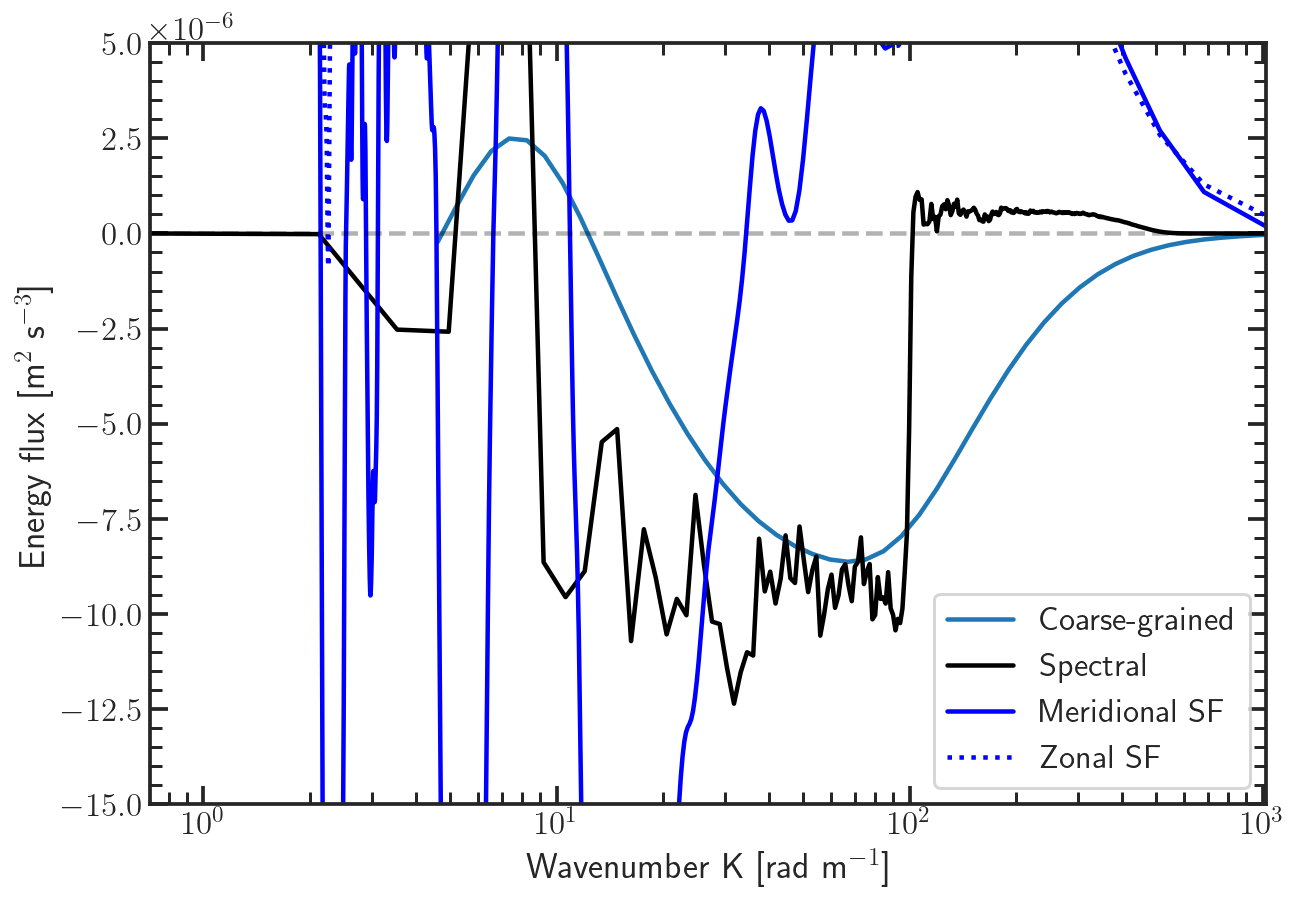

In [ ]:
dx = f['dx'][0]
dy = f['dy'][0]

fig, (ax1) = plt.subplots(figsize=(10, 7))
plt.semilogx((2*np.pi)/(l_all*dx),sfs_flux_pickle,label='Coarse-grained')
plt.semilogx(df_fluxes['kr'],df_fluxes['KE_Flux'],color='k',label='Spectral')
plt.semilogx((2*np.pi)/(f_adv_periodic['x-diffs']), 0.5*(f_adv_periodic['SF_meridional']), color="b", label="Meridional SF")
plt.semilogx((2*np.pi)/(f_adv_periodic['y-diffs']), 0.5*(f_adv_periodic['SF_zonal']), color="b", label="Zonal SF", linestyle='dotted')
plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.ylabel(r'Energy flux [m$^2$ s$^{-3}$]')
plt.hlines(0,df_fluxes['kr'].min(),df_fluxes['kr'].max(),color='k',linestyle='dashed',alpha=0.3)
plt.ylim(-15e-6,5e-6)
plt.xlim(df_fluxes['kr'].min(),df_fluxes['kr'].max())
ax1.tick_params(direction="in", which="both")
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

## Multiple files

In [10]:
sfs_flux_all = pd.read_pickle('sfs_pickles/sfs_flux_all_data2023-10-04_110050.pickle')
sfs_struct_all = pd.read_pickle('sfs_pickles/structsfs_sims_data2023-10-06_161524.pickle')

In [11]:
sfs_flux_df = pd.concat(sfs_flux_all)

In [12]:
dx = f['dx'][0]
dy = f['dy'][0]

sigma_all = np.logspace(np.log10(1e-3), np.log10(1e2), int(1e2))

l_all = np.sqrt(2) * sigma_all * np.pi
l_all_scaled = l_all * dx
k_sim = (2*np.pi)/(l_all * dx)

In [13]:
betay_10_data = [d.rename(columns={"SF_velocity": "SFv_adv", "SF_vorticity": "SFs_adv", "beta_y": "beta_y", "t": "t"}) for d in sfs_struct_all]

mean_SF_velocity_meridional = sum(
    d["SFv_adv"]["SF_meridional"] for d in betay_10_data
) / len(betay_10_data)
mean_SF_velocity_zonal = sum(
    d["SFv_adv"]["SF_zonal"] for d in betay_10_data
) / len(betay_10_data)

mean_SF_scalar_meridional = sum(
    d["SFs_adv"]["SF_meridional"] for d in betay_10_data
) / len(betay_10_data)
mean_SF_scalar_zonal = sum(
    d["SFs_adv"]["SF_zonal"] for d in betay_10_data
) / len(betay_10_data)

xdiffs = betay_10_data[0]["SFv_adv"]["x-diffs"]
ydiffs = betay_10_data[0]["SFv_adv"]["y-diffs"]    

SF_velocity_zonals = []
SF_velocity_meridionals = []
SF_scalar_zonals = []
SF_scalar_meridionals = []

for d in betay_10_data:
    SF_velocity_zonals.append(d["SFv_adv"]["SF_zonal"])
    SF_velocity_meridionals.append(d["SFv_adv"]["SF_meridional"])
    SF_scalar_zonals.append(d["SFs_adv"]["SF_zonal"])
    SF_scalar_meridionals.append(d["SFs_adv"]["SF_meridional"])

boot_SF_vz_adv = bootstrap((SF_velocity_zonals,), np.mean, confidence_level=0.9, axis=0)
boot_SF_vm_adv = bootstrap((SF_velocity_meridionals,), np.mean, confidence_level=0.9, axis=0)   
boot_SF_sz_adv = bootstrap((SF_scalar_zonals,), np.mean, confidence_level=0.9, axis=0)
boot_SF_sm_adv = bootstrap((SF_scalar_meridionals,), np.mean, confidence_level=0.9, axis=0)   

kd_sim = (2*np.pi)/(xdiffs)

boot_SF_vz_conf_adv = boot_SF_vz_adv.confidence_interval
boot_SF_vm_conf_adv = boot_SF_vm_adv.confidence_interval
boot_SF_sz_conf_adv = boot_SF_sz_adv.confidence_interval
boot_SF_sm_conf_adv = boot_SF_sm_adv.confidence_interval

boot_SF_vz_mean_adv = boot_SF_vz_adv.bootstrap_distribution.mean(axis=1)
boot_SF_vm_mean_adv = boot_SF_vm_adv.bootstrap_distribution.mean(axis=1)
boot_SF_sz_mean_adv = boot_SF_sz_adv.bootstrap_distribution.mean(axis=1)
boot_SF_sm_mean_adv = boot_SF_sm_adv.bootstrap_distribution.mean(axis=1)


In [14]:
sfs_energy_fluxes_list = [sfs_flux_df.groupby('time').get_group(time).sort_values("sigma")['SFS_energy_flux'] for time in sfs_flux_df["time"].drop_duplicates()]
sfs_enstrophy_fluxes_list = [sfs_flux_df.groupby('time').get_group(time).sort_values("sigma")['SFS_enstrophy_flux'] for time in sfs_flux_df["time"].drop_duplicates()]

In [15]:
boot_energy = bootstrap((sfs_energy_fluxes_list,), np.mean, confidence_level=0.9, axis=0)
boot_enstrophy = bootstrap((sfs_enstrophy_fluxes_list,), np.mean, confidence_level=0.9, axis=0)

In [16]:
boot_energy0 = boot_energy.confidence_interval[0]
boot_energy1 = boot_energy.confidence_interval[1]
boot_energy_mean = boot_energy.bootstrap_distribution.mean(axis=1)

boot_enstrophy0 = boot_enstrophy.confidence_interval[0]
boot_enstrophy1 = boot_enstrophy.confidence_interval[1]
boot_enstrophy_mean = boot_enstrophy.bootstrap_distribution.mean(axis=1)

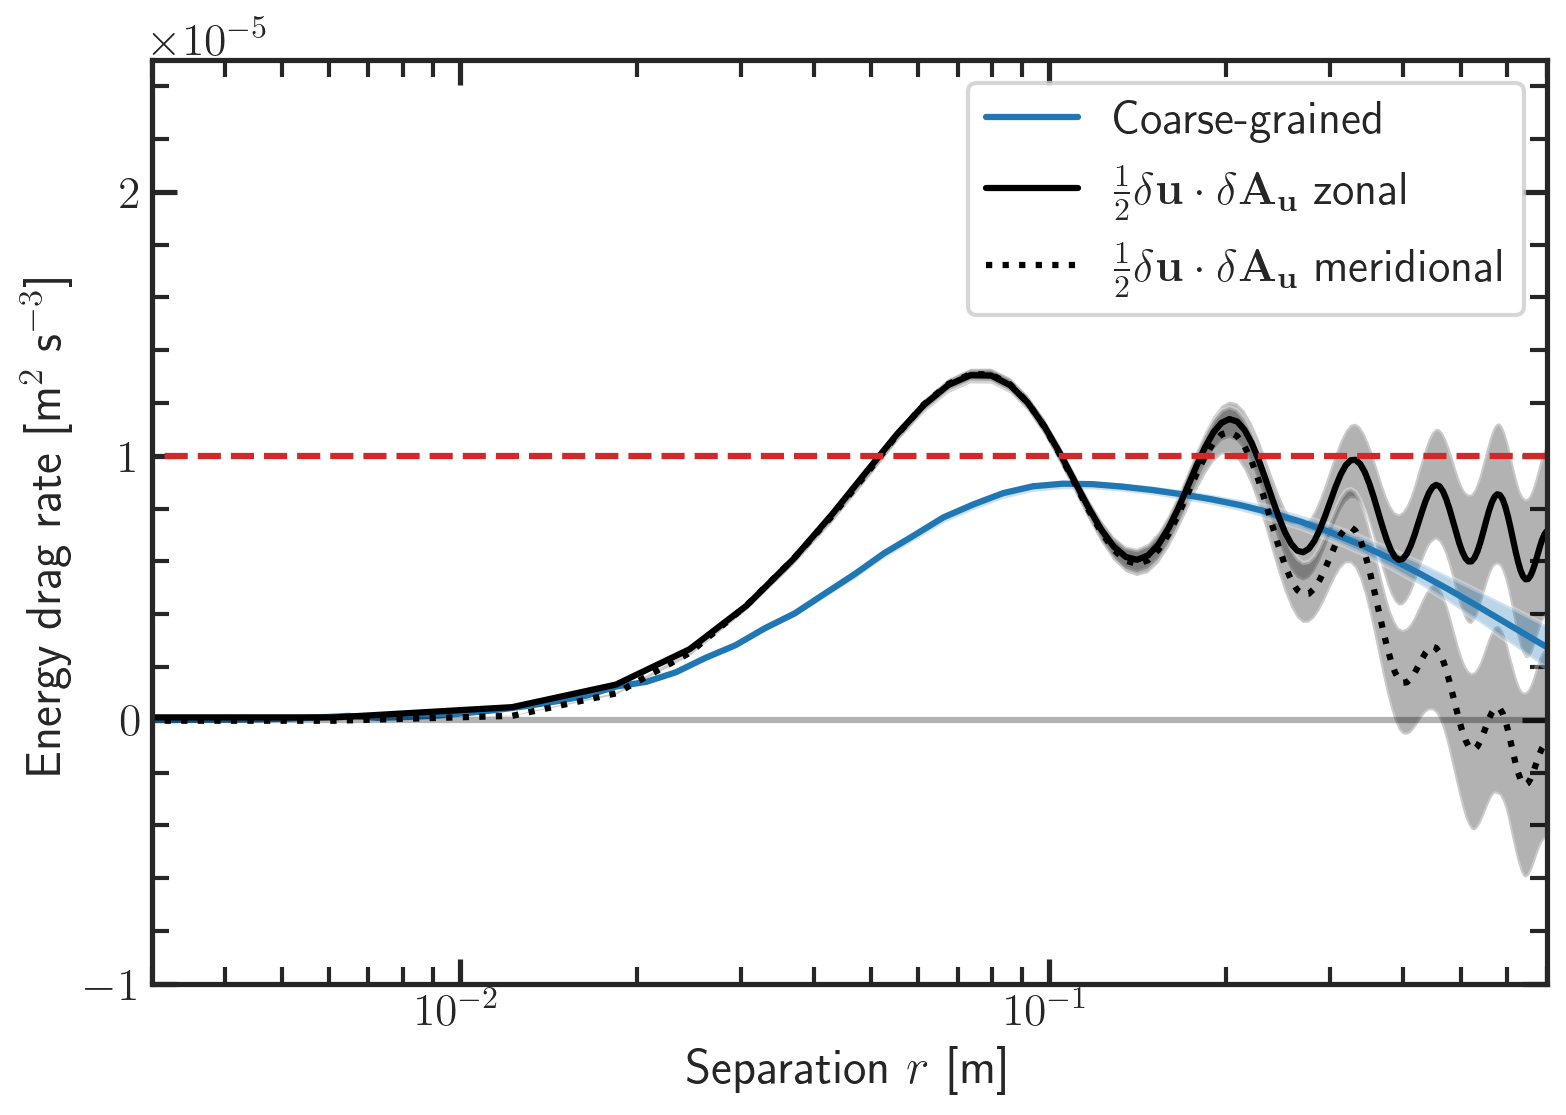

In [27]:
fig,ax = plt.subplots()

x_cg = l_all_scaled #* np.log10(2)
# x_cg = k_sim

x_sf = xdiffs 
# x_sf = kd_sim

plt.semilogx(x_cg, -boot_energy_mean,label='Coarse-grained')
# plt.semilogx(df_fluxes['kr'],df_fluxes['KE_Flux'],color='k',label='Spectral')
plt.semilogx(x_sf, boot_SF_vz_mean_adv,color='k',label=r'$\frac{1}{2} \delta \bf{u}\cdot\delta \bf{A_u}$ zonal')
plt.fill_between(x_sf,boot_SF_vz_conf_adv[0],boot_SF_vz_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

plt.semilogx(x_sf, boot_SF_vm_mean_adv, color='k',label=r'$\frac{1}{2} \delta \bf{u}\cdot\delta \bf{A_u}$ meridional',linestyle='dotted')
plt.fill_between(x_sf,boot_SF_vm_conf_adv[0],boot_SF_vm_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel(r'Separation $r$ [m]')
plt.ylabel(r'Energy drag rate [m$^2$ s$^{-3}$]')
plt.hlines(0,1e-3,1e0,color='k',linestyle='solid',alpha=0.3)
plt.hlines(1e-5,1e-3,1e0,color='tab:red',linestyle='dashed')
plt.fill_between(x_cg,-boot_energy0,-boot_energy1,color='tab:blue',alpha=0.3,edgecolor=None)
plt.ylim(-1e-5,2.5e-5)
plt.xlim(3e-3,7e-1)
# plt.xlim(df_fluxes['kr'].min(),df_fluxes['kr'].max())
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.minorticks_on()
plt.ticklabel_format(style='sci', axis='y', scilimits=(-5,-5))
plt.legend()

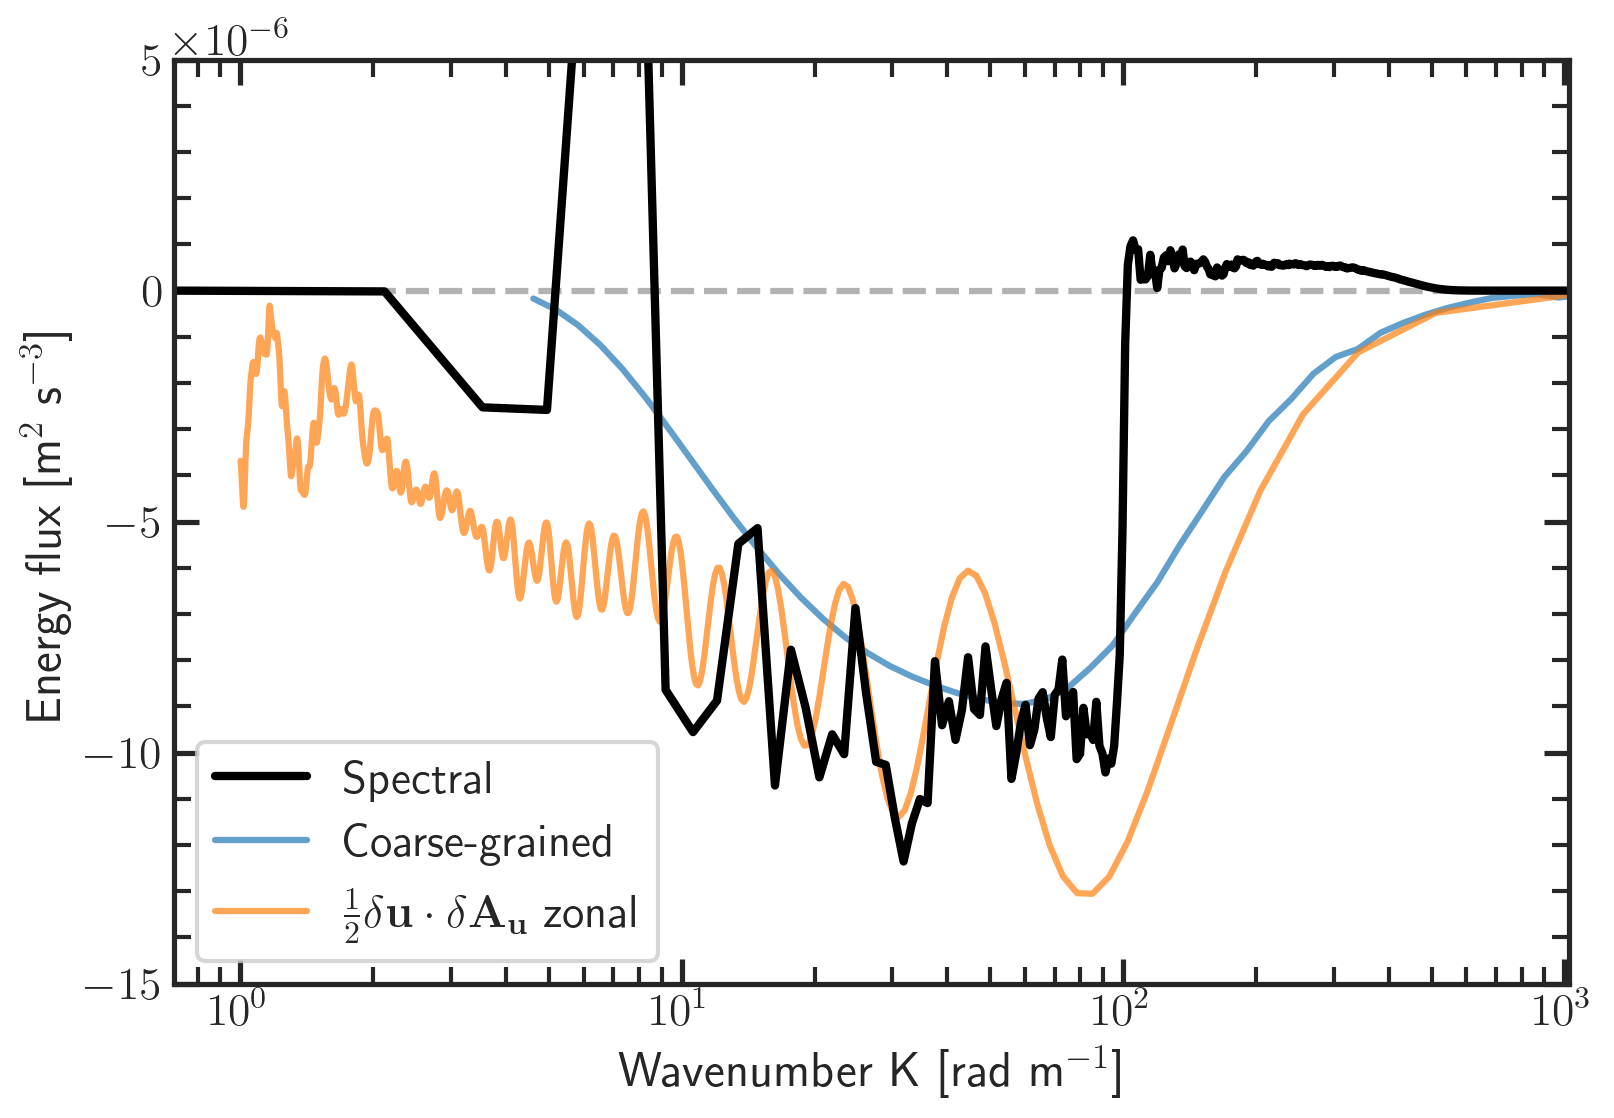

In [70]:
fig,ax = plt.subplots()

# x_cg = l_all_scaled #* np.log10(2)
x_cg = k_sim

# x_sf = xdiffs 
x_sf = kd_sim

plt.semilogx(x_cg, boot_energy_mean,label='Coarse-grained',color=plt.cm.tab10(0),alpha=0.7)
plt.semilogx(x_sf, -boot_SF_vz_mean_adv,color=plt.cm.tab10(1),label=r'$\frac{1}{2} \delta \bf{u}\cdot\delta \bf{A_u}$ zonal',alpha=0.7)
plt.semilogx(df_fluxes['kr'],df_fluxes['KE_Flux'],color='k',label='Spectral',linewidth=3)
# plt.fill_between(x_sf,-boot_SF_vz_conf_adv[0],-boot_SF_vz_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

# plt.semilogx(x_sf, -boot_SF_vm_mean_adv, color='k',label=r'$\frac{1}{2} \delta \bf{u}\cdot\delta \bf{A_u}$ meridional',linestyle='dotted')
# plt.fill_between(x_sf,-boot_SF_vm_conf_adv[0],-boot_SF_vm_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.ylabel(r'Energy flux [m$^2$ s$^{-3}$]')
plt.hlines(0,df_fluxes['kr'].min(),df_fluxes['kr'].max(),color='k',linestyle='dashed',alpha=0.3)
plt.hlines(1e-5,df_fluxes['kr'].min(),df_fluxes['kr'].max(),color='tab:red',linestyle='dashed')
# plt.fill_between(x_cg,boot_energy0,boot_energy1,color='tab:blue',alpha=0.3,edgecolor=None)
plt.ylim(-15e-6,5e-6)
plt.xlim(df_fluxes['kr'].min(),df_fluxes['kr'].max())
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.minorticks_on()
plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
# dx = f['dx'][0]
# dy = f['dy'][0]

# fig, (ax1) = plt.subplots(figsize=(10, 7))
# plt.semilogx((2*np.pi)/(l_all*dx),sfs_flux_pickle,label='Coarse-grained')
# plt.semilogx(df_fluxes['kr'],df_fluxes['KE_Flux'],color='k',label='Spectral')
# plt.semilogx((2*np.pi)/(f_adv_periodic['x-diffs']), 0.5*(f_adv_periodic['SF_meridional']), color="b", label="Meridional SF")
# plt.semilogx((2*np.pi)/(f_adv_periodic['y-diffs']), 0.5*(f_adv_periodic['SF_zonal']), color="b", label="Zonal SF", linestyle='dotted')
# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
# plt.ylabel(r'Energy flux [m$^2$ s$^{-3}$]')
# plt.hlines(0,df_fluxes['kr'].min(),df_fluxes['kr'].max(),color='k',linestyle='dashed',alpha=0.3)
# plt.ylim(-15e-6,5e-6)
# plt.xlim(df_fluxes['kr'].min(),df_fluxes['kr'].max())
# ax1.tick_params(direction="in", which="both")
# ax1.xaxis.get_ticklocs(minor=True)
# ax1.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
# plt.legend()

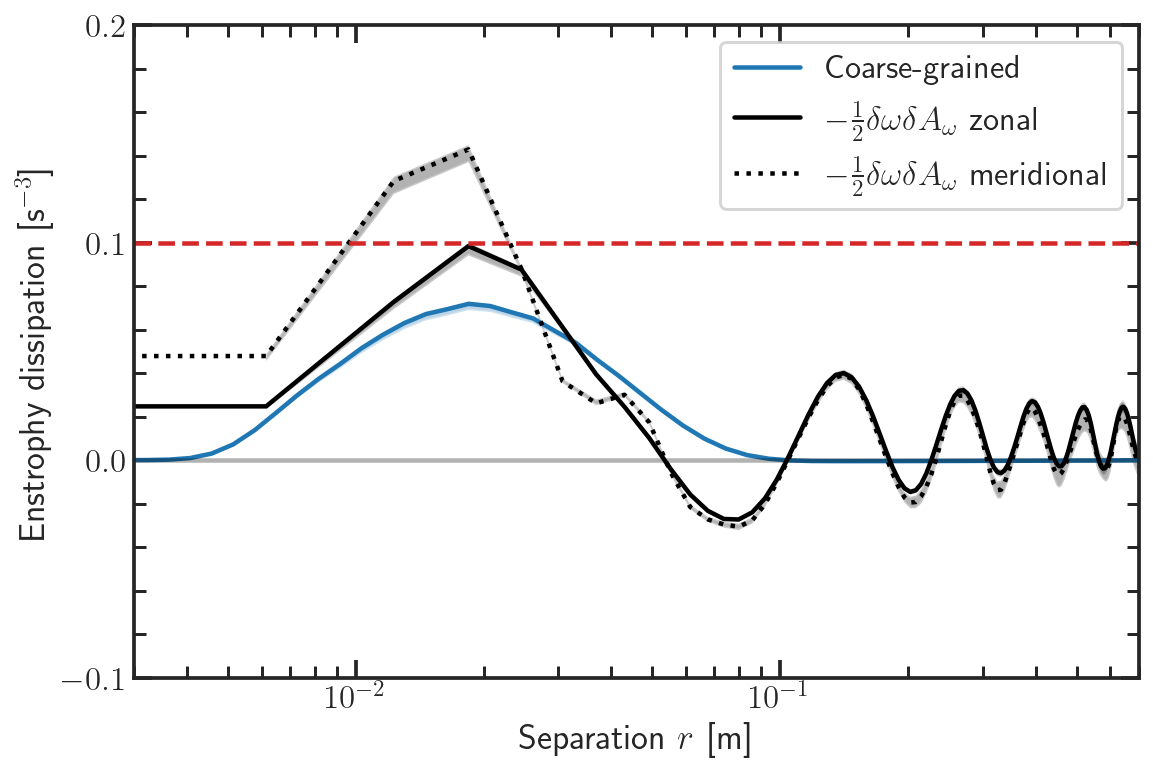

In [487]:
fig,ax = plt.subplots()

plt.semilogx(x_cg, boot_enstrophy_mean,label='Coarse-grained')

plt.semilogx(x_sf, -boot_SF_sz_mean_adv,color='k',label=r'$-\frac{1}{2}\delta \omega \delta A_{\omega}$ zonal')
plt.fill_between(x_sf,-boot_SF_sz_conf_adv[0],-boot_SF_sz_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

plt.semilogx(x_sf, -boot_SF_sm_mean_adv, color='k',label=r'$-\frac{1}{2}\delta \omega \delta A_{\omega}$ meridional', linestyle='dotted')
plt.fill_between(x_sf,-boot_SF_sm_conf_adv[0],-boot_SF_sm_conf_adv[1],color='k',alpha=0.3,edgecolor=None)

# plt.fill_between(kd_sim,2 * boot_SF_vz_conf_adv[0] / kd_sim**2,2 * boot_SF_vz_conf_adv[1] / kd_sim**2,color='tab:orange',alpha=0.3,edgecolor=None)

# plt.semilogx(kd_sim, 2 * boot_SF_vm_mean_adv / kd_sim**2, color='tab:green',label='Meridional')
# plt.fill_between(kd_sim,2 * boot_SF_vm_conf_adv[0] / kd_sim**2,2 * boot_SF_vm_conf_adv[1] / kd_sim**2,color='tab:green',alpha=0.3,edgecolor=None)
# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel(r'Separation $r$ [m]')
plt.ylabel(r'Enstrophy dissipation [s$^{-3}$]')
plt.hlines(0,3e-3,7e-1,color='k',linestyle='solid',alpha=0.3)
plt.hlines(1e-1,3e-3,7e-1,color='tab:red',linestyle='dashed')
plt.fill_between(x_cg,boot_enstrophy0,boot_enstrophy1,color='tab:blue',alpha=0.3,edgecolor=None)
plt.ylim(-0.1,0.2)
plt.xlim(3e-3,7e-1)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

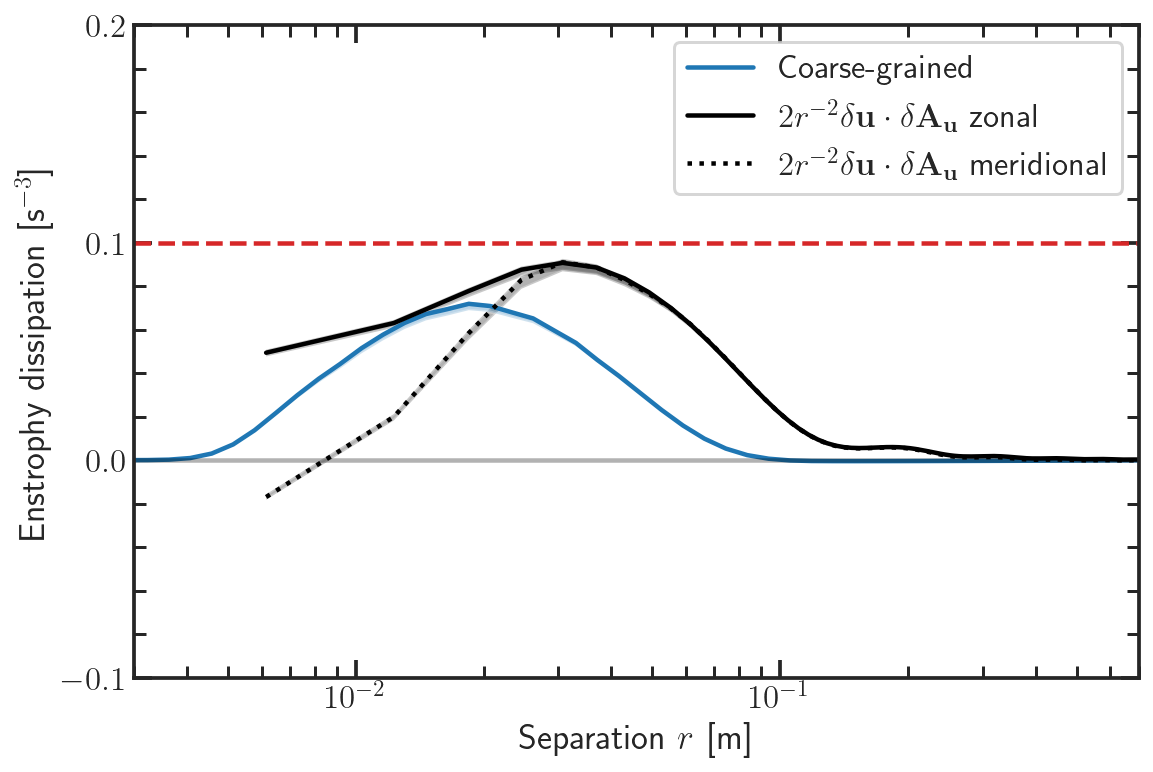

In [486]:
fig,ax = plt.subplots()

plt.semilogx(x_cg, boot_enstrophy_mean,label='Coarse-grained')

plt.semilogx(x_sf, 0.5*boot_SF_vz_mean_adv * kd_sim**2,color='k',label=r'$2 r^{-2} \delta \bf{u}\cdot\delta \bf{A_u}$ zonal')
plt.fill_between(x_sf,0.5*boot_SF_vz_conf_adv[0] * kd_sim**2,0.5*boot_SF_vz_conf_adv[1] * kd_sim**2,color='k',alpha=0.3,edgecolor=None)

plt.semilogx(x_sf, 0.5*boot_SF_vm_mean_adv * kd_sim**2, color='k',label=r'$2 r^{-2} \delta \bf{u}\cdot\delta \bf{A_u}$ meridional',linestyle='dotted')
plt.fill_between(x_sf,0.5*boot_SF_vm_conf_adv[0] * kd_sim**2,0.5*boot_SF_vm_conf_adv[1] * kd_sim**2,color='k',alpha=0.3,edgecolor=None)

# plt.fill_between(kd_sim,2 * boot_SF_vz_conf_adv[0] / kd_sim**2,2 * boot_SF_vz_conf_adv[1] / kd_sim**2,color='tab:orange',alpha=0.3,edgecolor=None)

# plt.semilogx(kd_sim, 2 * boot_SF_vm_mean_adv / kd_sim**2, color='tab:green',label='Meridional')
# plt.fill_between(kd_sim,2 * boot_SF_vm_conf_adv[0] / kd_sim**2,2 * boot_SF_vm_conf_adv[1] / kd_sim**2,color='tab:green',alpha=0.3,edgecolor=None)
# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel(r'Separation $r$ [m]')
plt.ylabel(r'Enstrophy dissipation [s$^{-3}$]')
plt.hlines(0,3e-3,7e-1,color='k',linestyle='solid',alpha=0.3)
plt.hlines(1e-1,3e-3,7e-1,color='tab:red',linestyle='dashed')
plt.fill_between(x_cg,boot_enstrophy0,boot_enstrophy1,color='tab:blue',alpha=0.3,edgecolor=None)
plt.ylim(-0.1,0.2)
plt.xlim(3e-3,7e-1)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.set_yticks(ax.get_yticks()[::2])
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

## SWOT CG compared with SF

In [4]:
with open('sfs_pickles/sfs_flux_pacific_swot_data2023-10-19_141705.pickle', 'rb') as handle:
    sfs_flux_all_swot = pickle.load(handle)

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [33]:
with open('../swot_sf_analysis/sf_pickles/sf_adv_pacific_swot_data_small2023-10-17_145938.pickle', 'rb') as handle:
    sf_adv_pacific_swot, processed_ds = pickle.load(handle)

In [34]:
SF_z = []
SF_m = []

for sf in sf_adv_pacific_swot:
    SF_z.append(sf["SF_zonal"])
    SF_m.append(sf["SF_meridional"])

SF_z = np.asarray([a[: len(min(SF_z, key=len))] for a in SF_z])
SF_m = np.asarray([a[: len(min(SF_m, key=len))] for a in SF_m])

boot_SF_vz = bootstrap((SF_z,), np.mean, confidence_level=0.9, axis=0)
boot_SF_vm = bootstrap((SF_m,), np.mean, confidence_level=0.9, axis=0)

boot_SF_vz_conf = boot_SF_vz.confidence_interval
boot_SF_vm_conf = boot_SF_vm.confidence_interval

boot_SF_vz_mean = boot_SF_vz.bootstrap_distribution.mean(axis=1)
boot_SF_vm_mean = boot_SF_vm.bootstrap_distribution.mean(axis=1)

xd_uneven = sf_adv_pacific_swot[0]["x-diffs"][: len(boot_SF_vm_mean)]
yd_uneven = sf_adv_pacific_swot[0]["y-diffs"][: len(boot_SF_vz_mean)]

In [70]:
dx = 2000
dy = 2000

num_its = int(1e2)
# sigma_all = np.logspace(np.log10(1e-3), np.log10(1e2), num_its)
# size1_all = np.logspace(np.log10(1), np.log10(3e3), num_its)
# size2_all = np.logspace(np.log10(1), np.log10(3e3), num_its)
# dist_all = np.sqrt(size1_all**2 + size2_all**2)
# l_all = np.sqrt(2) * dist_all * np.pi
l_all = np.linspace(0, 100, num_its)
l_swot_scaled = l_all * dx
k_swot = (2*np.pi)/(l_all*dx)

In [86]:
sfs_df_swot = pd.concat(sfs_flux_all_swot[0])
# sfs_df_swot['dist'] = np.sqrt(sfs_df_swot.s1**2 + sfs_df_swot.s2**2)

In [87]:
sfs_energy_fluxes_swot_list = [sfs_df_swot.groupby('filename').get_group(filename).sort_values("l")['SFS_energy_flux'] for filename in sfs_df_swot["filename"].drop_duplicates()]
sfs_enstrophy_fluxes_swot_list = [sfs_df_swot.groupby('filename').get_group(filename).sort_values("l")['SFS_enstrophy_flux'] for filename in sfs_df_swot["filename"].drop_duplicates()]
sfs_distances_swot_list = [sfs_df_swot.groupby('filename').get_group(filename).sort_values("l")['l'] for filename in sfs_df_swot["filename"].drop_duplicates()]

In [88]:
boot_energy_swot = bootstrap((sfs_energy_fluxes_swot_list,), np.mean, confidence_level=0.9, axis=0)
boot_enstrophy_swot = bootstrap((sfs_enstrophy_fluxes_swot_list,), np.mean, confidence_level=0.9, axis=0)

In [89]:
boot_energy0_swot = boot_energy_swot.confidence_interval[0]
boot_energy1_swot = boot_energy_swot.confidence_interval[1]
boot_energy_mean_swot = boot_energy_swot.bootstrap_distribution.mean(axis=1)

boot_enstrophy0_swot = boot_enstrophy_swot.confidence_interval[0]
boot_enstrophy1_swot = boot_enstrophy_swot.confidence_interval[1]
boot_enstrophy_mean_swot = boot_enstrophy_swot.bootstrap_distribution.mean(axis=1)

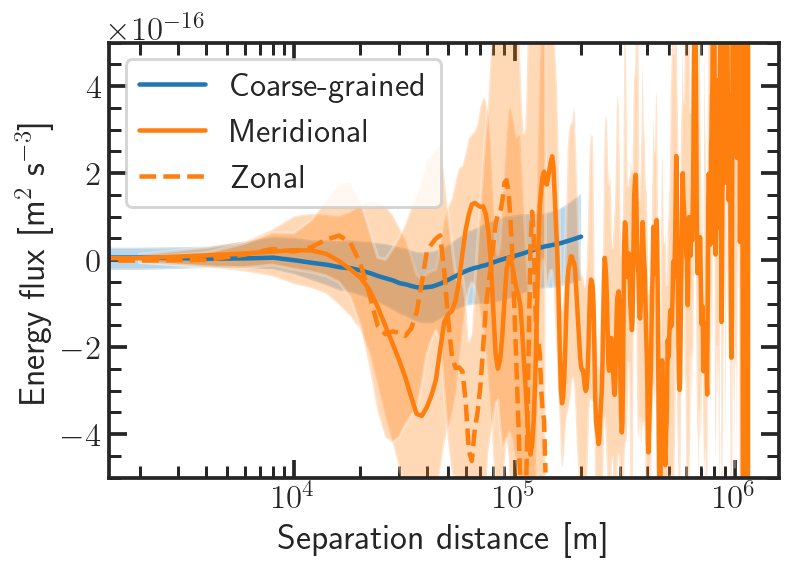

In [103]:
fig,ax = plt.subplots()

plt.semilogx(l_swot_scaled, boot_energy_mean_swot,label='Coarse-grained')
plt.fill_between(l_swot_scaled,boot_energy0_swot,boot_energy1_swot,color='tab:blue',alpha=0.3,edgecolor=None)

plt.semilogx(xd_uneven, -0.5 * boot_SF_vm_mean, label='Meridional',color='tab:orange')
plt.fill_between(xd_uneven,-0.5 * boot_SF_vm_conf[0],-0.5 * boot_SF_vm_conf[1],color='tab:orange',alpha=0.3,edgecolor=None)

plt.semilogx(yd_uneven, -0.5 * boot_SF_vz_mean, label='Zonal',color='tab:orange',linestyle='dashed')
plt.fill_between(yd_uneven,-0.5 * boot_SF_vz_conf[0],-0.5 * boot_SF_vz_conf[1],color='tab:orange',alpha=0.3,edgecolor=None)

# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel('Separation distance [m]')
plt.ylabel(r'Energy flux [m$^2$ s$^{-3}$]')
# plt.hlines(0,l_all_scaled.min(),l_all_scaled.max(),color='k',linestyle='dashed',alpha=0.3)
# plt.hlines(0,2e3,3e6,color='k',linestyle='dashed',alpha=0.3)
plt.ylim(-5e-16,5e-16)
# plt.xlim(l_all_scaled.min(),l_all_scaled.max())
# plt.xlim(2e3,3e6)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

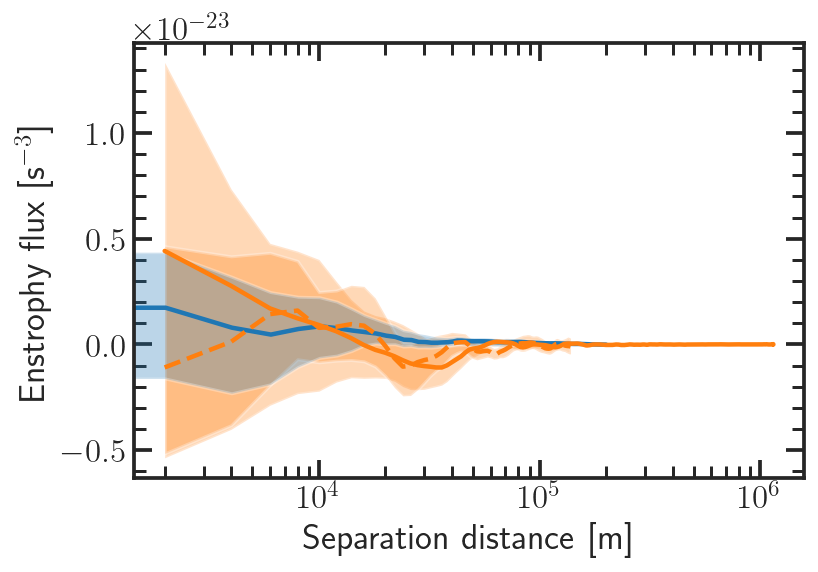

In [96]:
fig,ax = plt.subplots()

plt.semilogx(l_swot_scaled, boot_enstrophy_mean_swot,label='Coarse-grained')

plt.semilogx(xd_uneven, -2 * boot_SF_vm_mean / xd_uneven**2, label='Meridional',color='tab:orange')
plt.fill_between(xd_uneven, -2 * boot_SF_vm_conf[0] / xd_uneven**2,-2 * boot_SF_vm_conf[1] / xd_uneven**2,color='tab:orange',alpha=0.3,edgecolor=None)

plt.semilogx(yd_uneven, -2 * boot_SF_vz_mean / yd_uneven**2, label='Zonal',color='tab:orange',linestyle='dashed')
plt.fill_between(yd_uneven,-2 * boot_SF_vz_conf[0] / yd_uneven**2,-2 * boot_SF_vz_conf[1] / yd_uneven**2,color='tab:orange',alpha=0.3,edgecolor=None)

# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel('Separation distance [m]')
plt.ylabel(r'Enstrophy flux [s$^{-3}$]')
# plt.hlines(0,l_all_scaled.min(),l_all_scaled.max(),color='k',linestyle='dashed',alpha=0.3)
# plt.hlines(0,2e3,3e6,color='k',linestyle='dashed',alpha=0.3)
plt.fill_between(l_swot_scaled,boot_enstrophy0_swot,boot_enstrophy1_swot,color='tab:blue',alpha=0.3,edgecolor=None)
# plt.ylim(-15e-6,5e-6)
# plt.xlim(l_all_scaled.min(),l_all_scaled.max())
# plt.xlim(2e3,3e6)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
# plt.legend()

## SWOT SF

In [ ]:
swot_ds_test = xr.open_dataset('/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/swot_sf_analysis/data/acc_data/SWOT_L2_LR_SSH_Expert_001_002_20111113T005126_20111113T014253_DG10_01.nc')

In [ ]:
latmin = -70
latmax = -50
lonmin = 0
lonmax = 360

dx = 2000
dy = 2000

swot_ds_test.simulated_true_ssh_karin.attrs["units"] = "cm"
swot_ds_test_cut = swot_ds_test.where(
    (swot_ds_test.latitude > latmin)
    & (swot_ds_test.latitude < latmax)
    & (swot_ds_test.longitude < lonmax)
    & (swot_ds_test.longitude > lonmin),
    drop=True,
)

swot_ds_test_vels = swotan.geostrophic_velocity(swot_ds_test_cut, dx=dx, dy=dy)
swot_ds_test_rot = swotan.rotational_parameters(swot_ds_test_vels,dx=dx,dy=dy)

In [ ]:
swot_u_test = ((swot_ds_test_rot.u.values) * (u.cm / u.s)).si.value
swot_v_test = ((swot_ds_test_rot.v.values) * (u.cm / u.s)).si.value
swot_x_test = dx * swot_ds_test_rot.num_lines.values
swot_y_test = dy * swot_ds_test_rot.num_pixels.values

swot_sf_adv_test = ocsf.advection_velocity(swot_u_test, swot_v_test, swot_x_test, swot_y_test, boundary=None)
swot_sf_trad_test = ocsf.traditional_velocity(swot_u_test, swot_v_test, swot_x_test, swot_y_test, boundary=None)

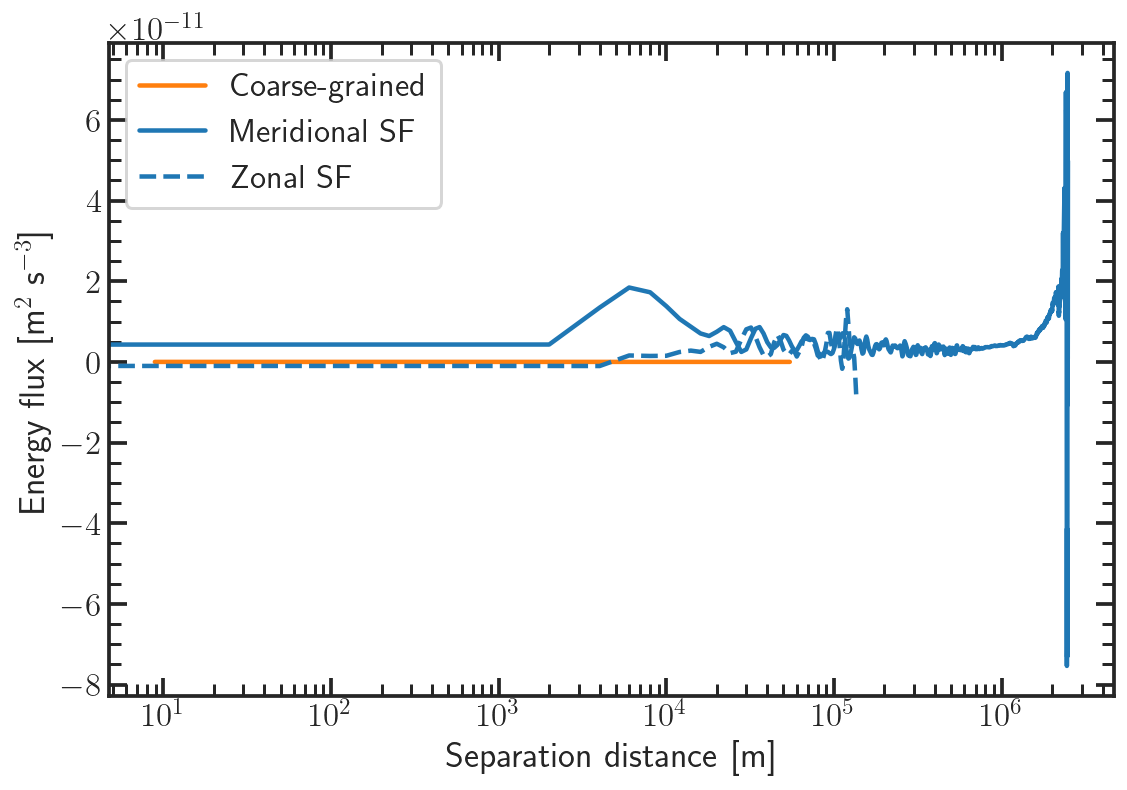

In [ ]:
fig,ax = plt.subplots()

plt.semilogx(l_swot_scaled, boot_energy_mean_swot,label='Coarse-grained',c='tab:orange')
plt.semilogx(swot_sf_adv_test['x-diffs'],0.5*swot_sf_adv_test['SF_meridional'],c='tab:blue',label='Meridional SF')
plt.semilogx(swot_sf_adv_test['y-diffs'],0.5*swot_sf_adv_test['SF_zonal'],c='tab:blue',linestyle='dashed',label='Zonal SF')
# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel('Separation distance [m]')
plt.ylabel(r'Energy flux [m$^2$ s$^{-3}$]')
# plt.hlines(0,l_all_scaled.min(),l_all_scaled.max(),color='k',linestyle='dashed',alpha=0.3)
# plt.hlines(0,2e3,3e6,color='k',linestyle='dashed',alpha=0.3)
plt.fill_between(l_swot_scaled,boot_energy0_swot,boot_energy1_swot,color='tab:orange',alpha=0.3,edgecolor=None)
# plt.ylim(-0.5e-6,0.1e-6)
# plt.xlim(l_all_scaled.min(),l_all_scaled.max())
# plt.xlim(8e-5,1e0)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

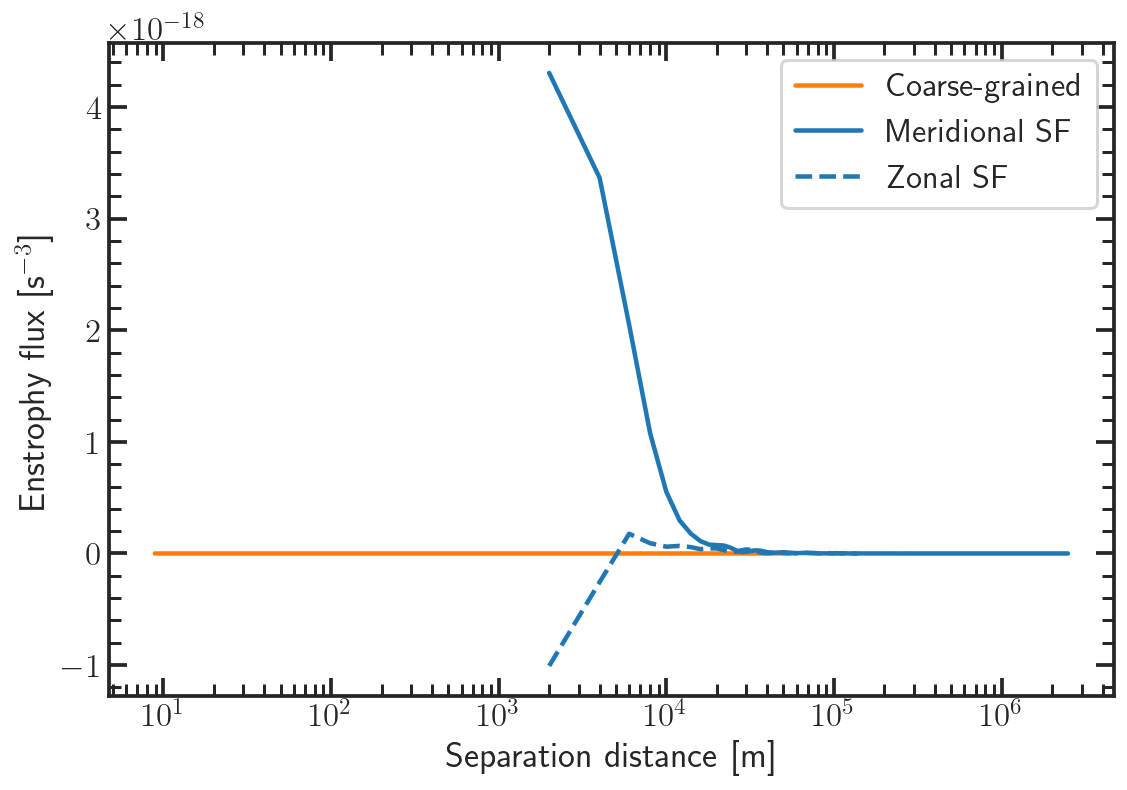

In [ ]:
fig,ax = plt.subplots()

plt.semilogx(l_swot_scaled, boot_enstrophy_mean_swot,label='Coarse-grained',c='tab:orange')
plt.semilogx(swot_sf_adv_test['x-diffs'],2*swot_sf_adv_test['SF_meridional'] / (swot_sf_adv_test['x-diffs'])**2,c='tab:blue',label='Meridional SF')
plt.semilogx(swot_sf_adv_test['y-diffs'],2*swot_sf_adv_test['SF_zonal'] / (swot_sf_adv_test['y-diffs'])**2,c='tab:blue',linestyle='dashed',label='Zonal SF')
# plt.xlabel(r'Wavenumber K [rad m$^{-1}$]')
plt.xlabel('Separation distance [m]')
plt.ylabel(r'Enstrophy flux [s$^{-3}$]')
# plt.hlines(0,l_all_scaled.min(),l_all_scaled.max(),color='k',linestyle='dashed',alpha=0.3)
# plt.hlines(0,2e3,3e6,color='k',linestyle='dashed',alpha=0.3)
plt.fill_between(l_swot_scaled,boot_enstrophy0_swot,boot_enstrophy1_swot,color='tab:orange',alpha=0.3,edgecolor=None)
# plt.ylim(-0.5e-6,0.1e-6)
# plt.xlim(l_all_scaled.min(),l_all_scaled.max())
# plt.xlim(8e-5,1e0)
ax.tick_params(direction="in", which="both")
ax.xaxis.get_ticklocs(minor=True)
ax.minorticks_on()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
plt.legend()

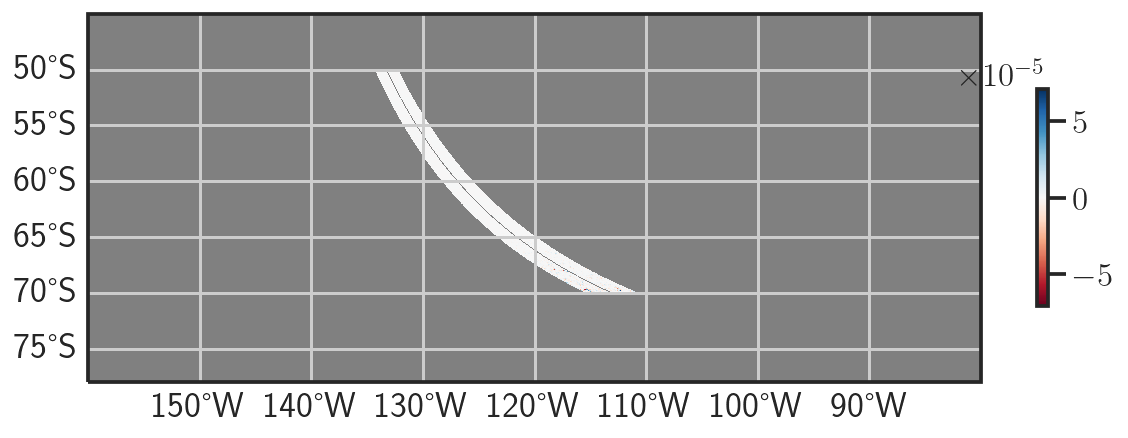

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
p = swot_ds_test_rot.adv_e.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu',add_colorbar=False
)

gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
ax.set_extent([-160,-80,-75,-45])
    # ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
    # plt.tight_layout()
cbar = fig.colorbar(p,cmap='RdBu',shrink=0.2)
plt.show()

## Testing advection and traditional SF methods to find order of magnitude error

In [ ]:
adv_E, adv_N = ocsf.calculate_velocity_advection(swot_u_test, swot_v_test, swot_x_test, swot_y_test)

In [ ]:
SF_m = np.zeros(int(1e3))
xd = np.zeros(int(1e3))
yd = np.zeros(int(1e3))

for i in range(1,int(1e3)):
    xroll = np.full(np.shape(swot_x_test), np.nan)
    yroll = np.full(np.shape(swot_y_test), np.nan)

    adv_E_roll = np.full(np.shape(adv_E), np.nan)
    adv_N_roll = np.full(np.shape(adv_N), np.nan)
    u_roll = np.full(np.shape(swot_u_test), np.nan)
    v_roll = np.full(np.shape(swot_v_test), np.nan)

    xroll[i:] = swot_x_test[:-i]
    yroll[i:] = swot_y_test[:-i]

    adv_E_roll[i:, :] = adv_E[:-i, :]
    adv_N_roll[i:, :] = adv_N[:-i, :]
    u_roll[i:, :] = swot_u_test[:-i, :]
    v_roll[i:, :] = swot_v_test[:-i, :]

    SF_m[i] = np.nanmean(
        (adv_E_roll - adv_E) * (u_roll - swot_u_test)
        + (adv_N_roll - adv_N) * (v_roll - swot_v_test)
    )

    # xd[i] = (np.abs(xroll - swot_x_test))[int(1e3)]
    # yd[i] = (np.abs(yroll - swot_y_test))[int(1e3)]

In [ ]:
i = 10

u_pad_test = np.pad(
    swot_u_test,
    ((0, 0), (i, 0)),
    mode="constant",
    constant_values=np.nan,
)[:, :-i]

u_numpy_roll = np.roll(swot_u_test, i,axis=1)

u_roll = np.full(np.shape(swot_u_test), np.nan)
u_roll[:, i:] = swot_u_test[:, :-i]


In [ ]:
((u_roll == u_pad_test) | (np.isnan(u_roll) & np.isnan(u_pad_test))).all()

True

In [ ]:
((u_roll == u_numpy_roll) | (np.isnan(u_roll) & np.isnan(u_numpy_roll))).all()

False

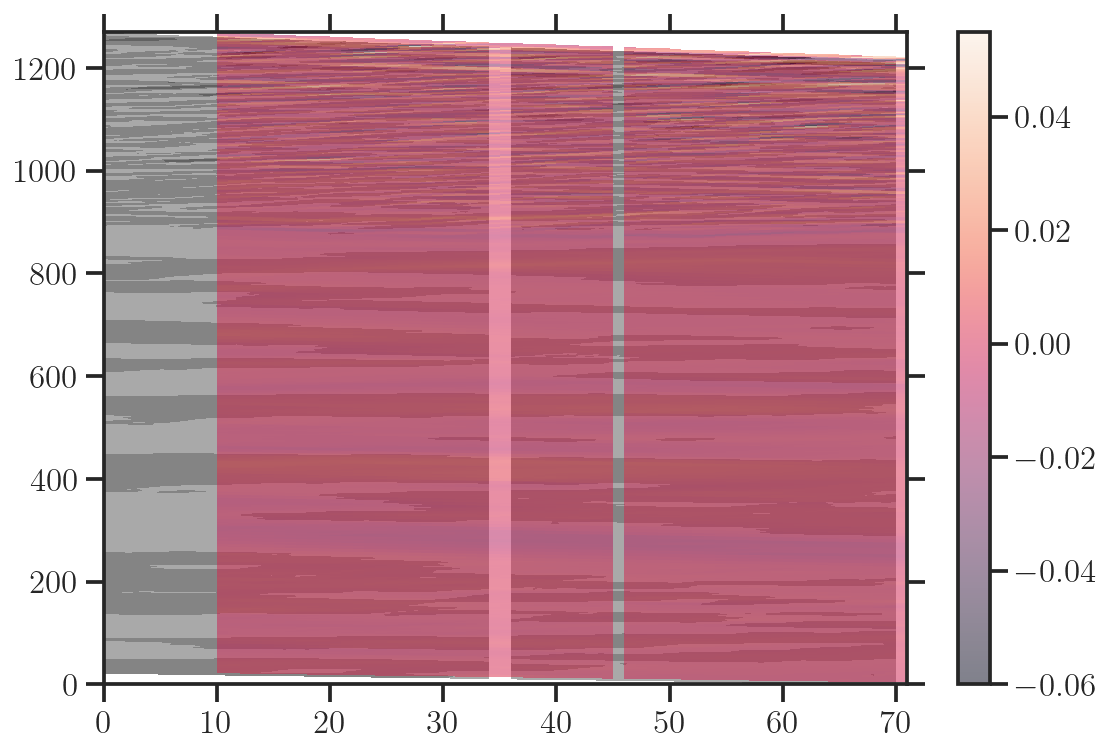

In [ ]:
plt.contourf(swot_u_test,cmap='Greys')
plt.pcolormesh(u_roll,alpha=0.5)
plt.colorbar()

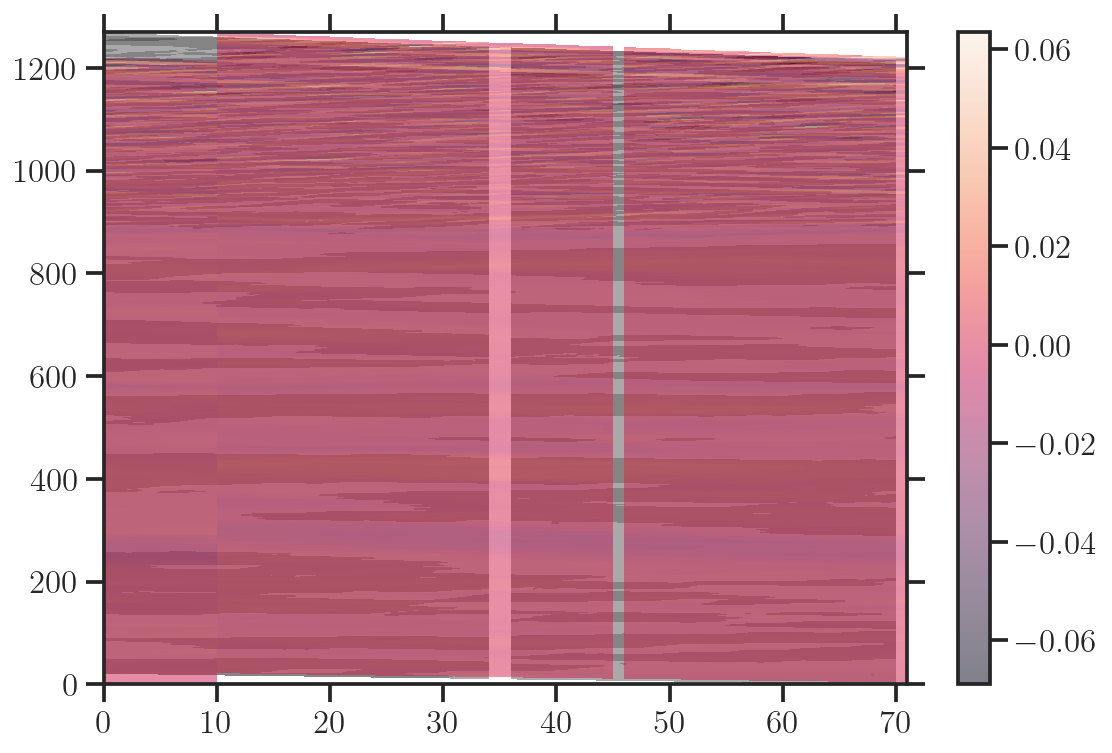

In [ ]:
plt.contourf(swot_u_test,cmap='Greys')
plt.pcolormesh(u_numpy_roll,alpha=0.5)
plt.colorbar()

In [ ]:
np.random.seed(1234)
tmparr = np.random.randint(1,6,size=(5,5))
tmparr

array([[4, 5, 5, 1, 2],
       [2, 2, 3, 4, 5],
       [5, 3, 3, 1, 1],
       [5, 1, 2, 3, 1],
       [4, 5, 3, 3, 4]])

In [ ]:
i = 2
np.roll(tmparr,i,axis=0)

array([[5, 1, 2, 3, 1],
       [4, 5, 3, 3, 4],
       [4, 5, 5, 1, 2],
       [2, 2, 3, 4, 5],
       [5, 3, 3, 1, 1]])

In [ ]:
my_roll_tmp = np.full(np.shape(tmparr), np.nan)
my_roll_tmp[:i, :] = tmparr[-i:, :]
my_roll_tmp[i:, :] = tmparr[:-i, :]
my_roll_tmp

array([[5., 1., 2., 3., 1.],
       [4., 5., 3., 3., 4.],
       [4., 5., 5., 1., 2.],
       [2., 2., 3., 4., 5.],
       [5., 3., 3., 1., 1.]])

In [ ]:
i_roll = 100

numpy_roll_u_sim = np.roll(f['u'],i_roll,axis=1)

my_roll_u_sim = np.full(np.shape(f['u']), np.nan)
my_roll_u_sim[:i, :] = f['u'][-i:, :]
my_roll_u_sim[i:, :] = f['u'][:-i, :]

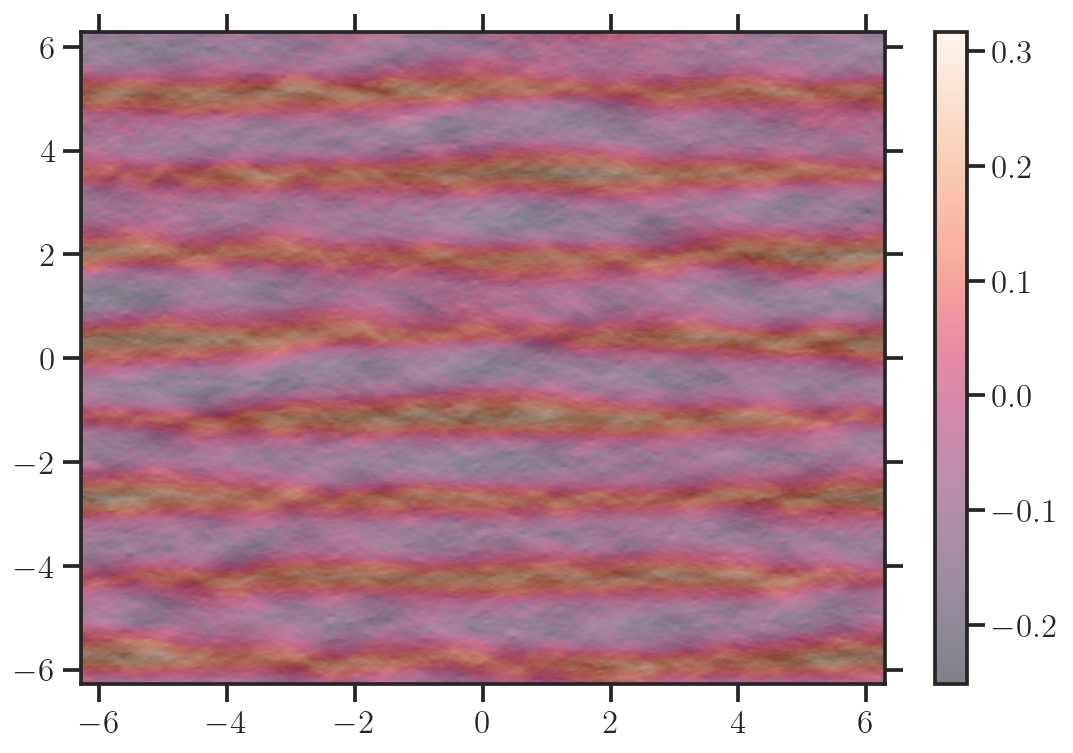

In [ ]:
plt.pcolormesh(x,y,f['u'],cmap='Greys')
plt.pcolormesh(x,y,numpy_roll_u_sim,alpha=0.5)
plt.colorbar()

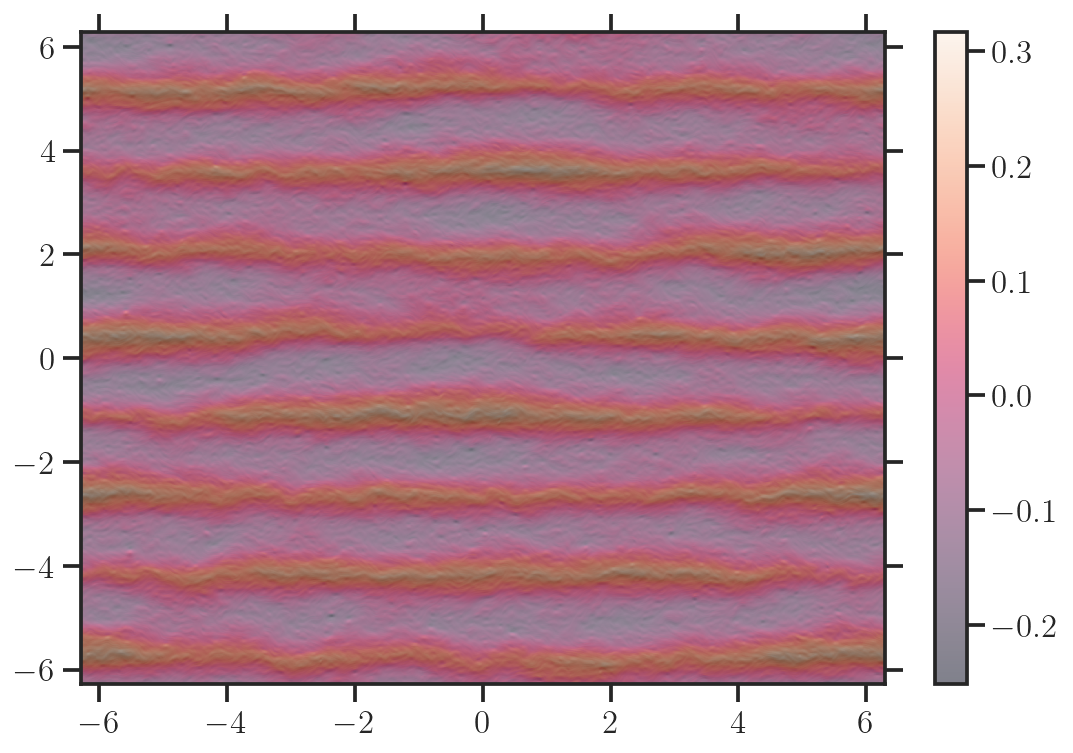

In [ ]:
plt.pcolormesh(x,y,f['u'],cmap='Greys')
plt.pcolormesh(x,y,my_roll_u_sim,alpha=0.5)
plt.colorbar()

In [ ]:
dx = np.abs(x[0] - x[1])
dy = np.abs(y[0] - y[1])

u_ip1 = np.roll(f['u'], -1, axis=1)
u_im1 = np.roll(f['u'], 1, axis=1)
v_ip1 = np.roll(f['v'], -1, axis=1)
v_im1 = np.roll(f['v'], 1, axis=1)

v_jp1 = np.roll(f['v'], -1, axis=0)
v_jm1 = np.roll(f['v'], 1, axis=0)
u_jp1 = np.roll(f['u'], -1, axis=0)
u_jm1 = np.roll(f['u'], 1, axis=0)

dudx = (u_ip1 - u_im1) / (2 * dx)
dvdx = (v_ip1 - v_im1) / (2 * dx)
dudy = (u_jp1 - u_jm1) / (2 * dy)
dvdy = (v_jp1 - v_jm1) / (2 * dy)

eastward_advection_roll = f['u'] * dudx + f['v'] * dudy
northward_advection_roll = f['u'] * dvdx + f['v'] * dvdy

In [ ]:
dx = np.abs(x[0] - x[1])
dy = np.abs(y[0] - y[1])

dudx, dudy = np.gradient(f['u'], dx, dy, axis=(1, 0))
dvdx, dvdy = np.gradient(f['v'], dx, dy, axis=(1, 0))

eastward_advection = f['u'] * dudx + f['v'] * dudy
northward_advection = f['u'] * dvdx + f['v'] * dvdy

## Testing Tophat filter with SWOT

In [4]:
from scipy.ndimage import uniform_filter, gaussian_filter
from scipy import interpolate
from scipy.signal import convolve

from swot_analysis import geostrophic_velocity
from swot_analysis import rotational_parameters

from astropy.convolution import convolve, convolve_fft

In [5]:
# For Pacific
latmin = 40
latmax = 50
lonmin = 0
lonmax = 360

# For ACC
# latmin = -70
# latmax = -50
# lonmin = 0
# lonmax = 360

dx = 2000
dy = 2000

filename = '/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/swot_sf_analysis/data/pacific_data/SWOT_L2_LR_SSH_Expert_001_002_20111113T005126_20111113T014253_DG10_01.nc'

ds = xr.open_dataset(filename)

# ds.ssh_karin.attrs["units"] = "cm"
ds_cut = ds.where(
    (ds.latitude > latmin)
    & (ds.latitude < latmax)
    & (ds.longitude < lonmax)
    & (ds.longitude > lonmin),
    drop=True,
)

# ds_vels = geostrophic_velocity(ds_cut, dx=dx, dy=dy)

# ds_rot = rotational_parameters(ds_vels, dx=dx, dy=dy)

In [6]:
swot_total_error = (
    ds_cut.simulated_error_phase + 
    ds_cut.simulated_error_roll + 
    ds_cut.simulated_error_timing + 
    ds_cut.simulated_error_baseline_dilation + 
    # ds_cut.simulated_error_karin + 
    # ds_cut.simulated_error_troposphere + 
    ds_cut.simulated_error_orbital
    )

swot_remove_some_error = ds_cut.ssh_karin - swot_total_error

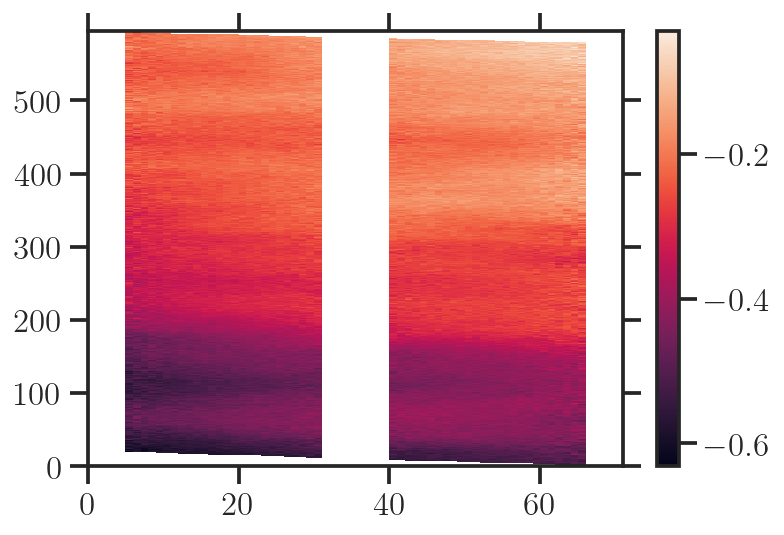

In [7]:
plt.pcolormesh(swot_remove_some_error)
plt.colorbar()

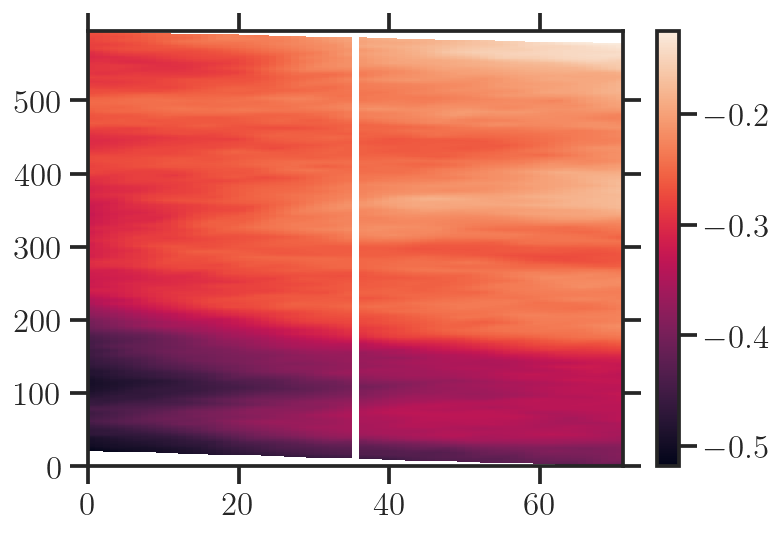

In [8]:
plt.pcolormesh(ds_cut.simulated_true_ssh_karin)
plt.colorbar()

In [9]:
from astropy.convolution import Tophat2DKernel

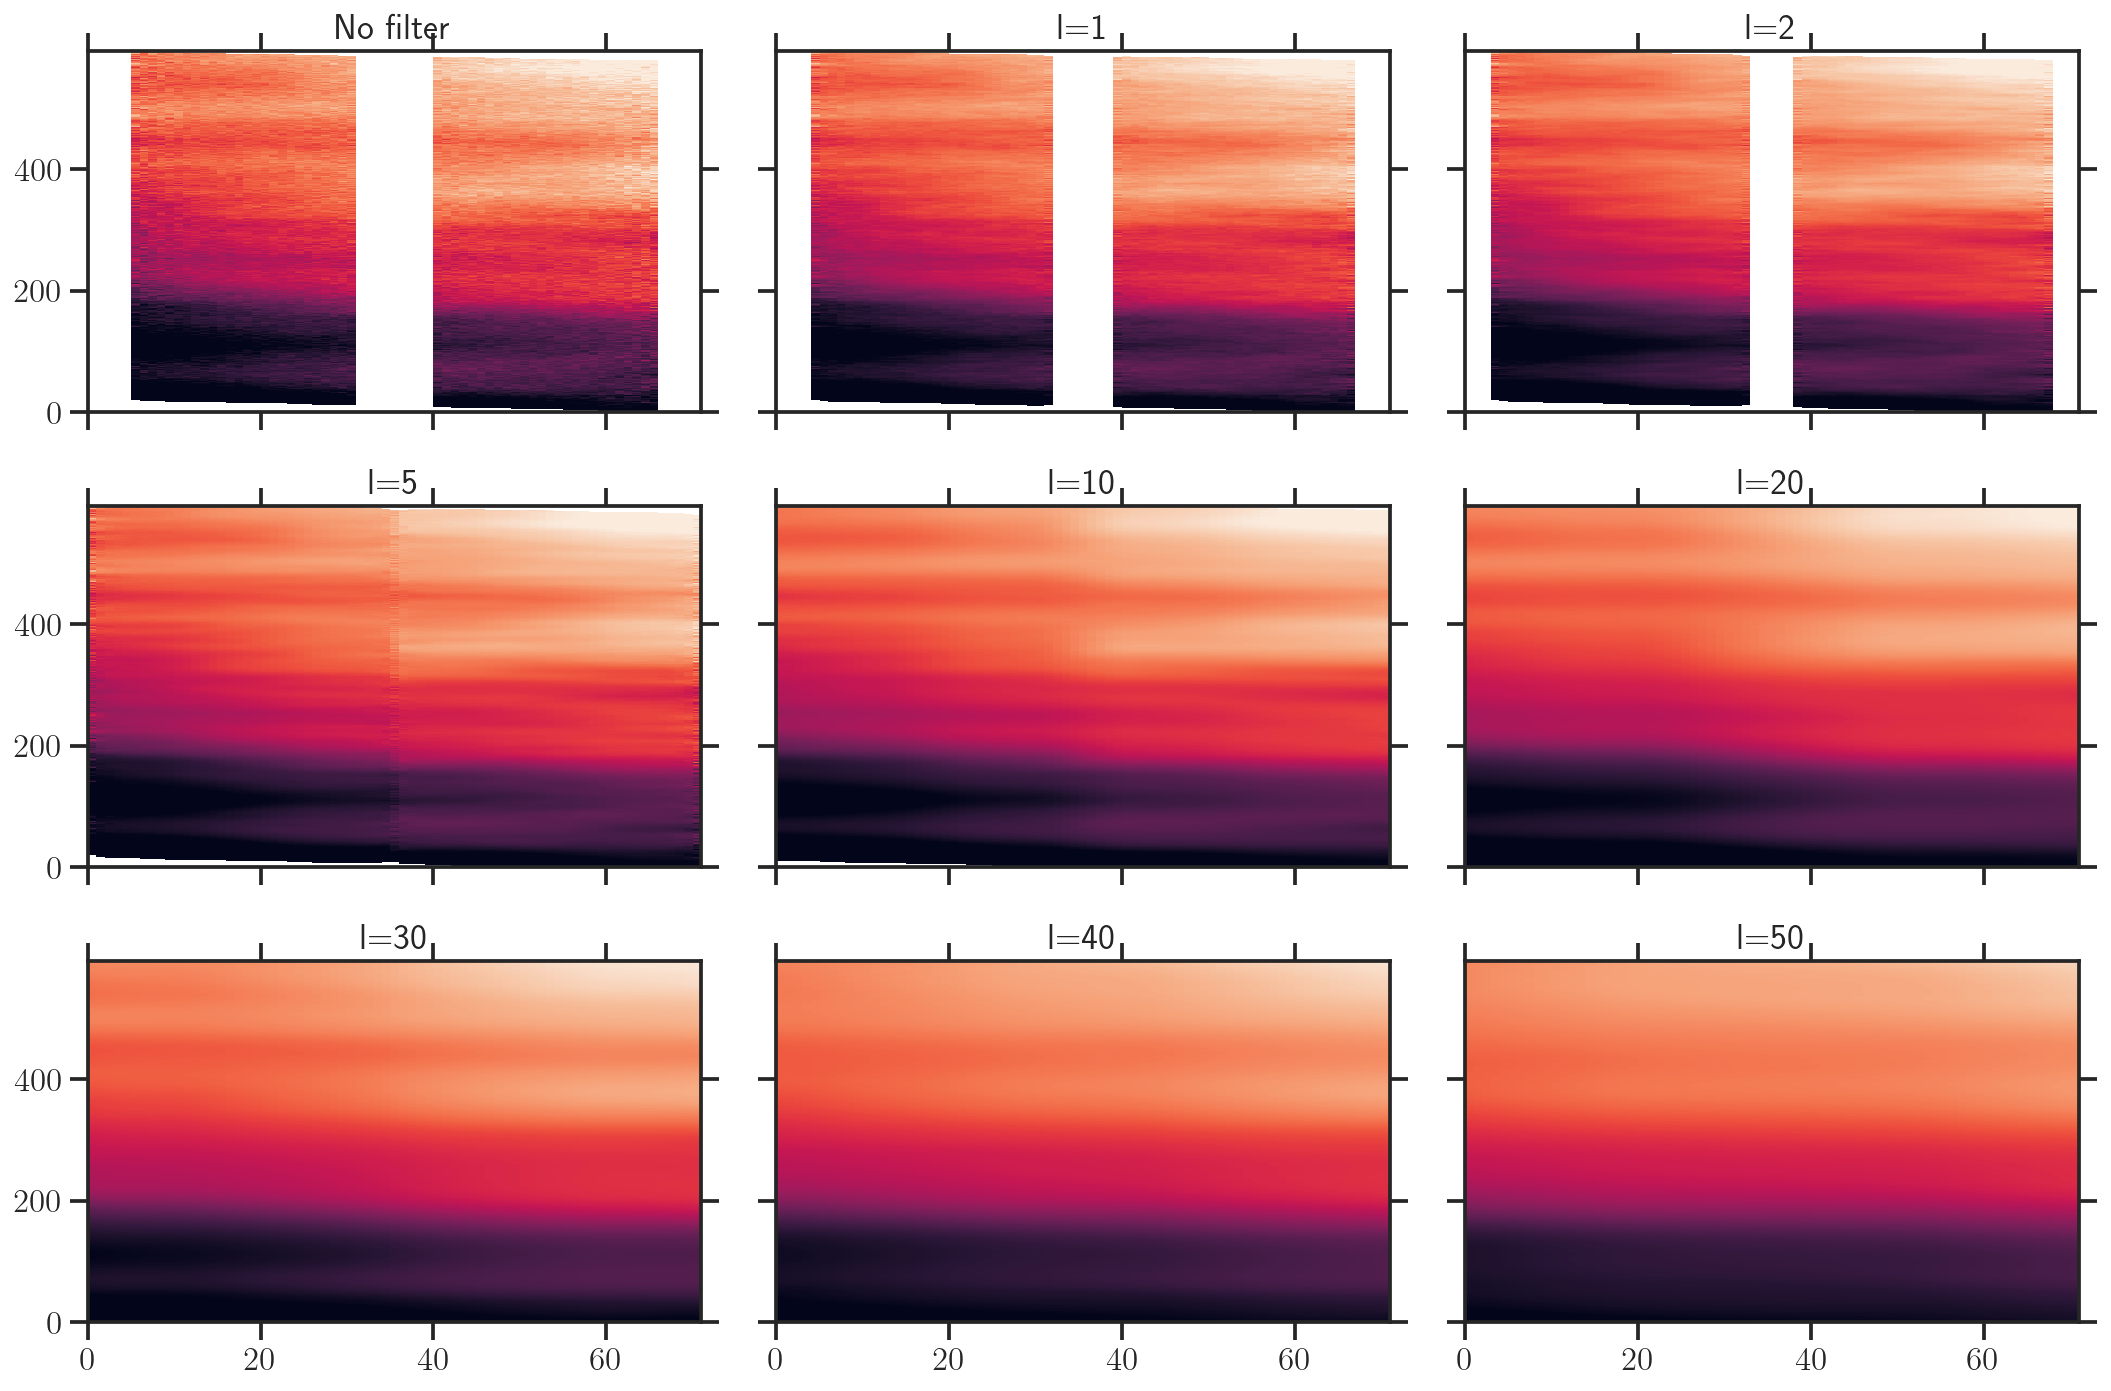

In [65]:
l_list = [1,2,5,10,20,30,40,50]

fig, axs = plt.subplots(3,3,sharex=True, sharey=True,figsize=(15,10))
axs[0,0].pcolormesh(swot_remove_some_error,vmin=-0.5,vmax=-0.1)
axs[0,0].set_title('No filter')
axs[0,1].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[0]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[0,1].set_title('l=%s' %l_list[0])
axs[0,2].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[1]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[0,2].set_title('l=%s' %l_list[1])

axs[1,0].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[2]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[1,0].set_title('l=%s' %l_list[2])
axs[1,1].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[3]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[1,1].set_title('l=%s' %l_list[3])
axs[1,2].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[4]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[1,2].set_title('l=%s' %l_list[4])

axs[2,0].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[5]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[2,0].set_title('l=%s' %l_list[5])
axs[2,1].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[6]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[2,1].set_title('l=%s' %l_list[6])
axs[2,2].pcolormesh(convolve(swot_remove_some_error,Tophat2DKernel(l_list[7]),boundary='extend'),vmin=-0.5,vmax=-0.1)
axs[2,2].set_title('l=%s' %l_list[7])


plt.tight_layout()
# axs[0,0].axis('off')
# axs[0,1].axis('off')
# axs[0,2].axis('off')
# axs[1,0].axis('off')
# axs[2,0].axis('off')
# axs[1,1].axis('off')
# axs[1,2].axis('off')
# axs[2,2].axis('off')
# axs[2,1].axis('off')

In [92]:
l1=1e3
l2=1e2
l=1e3

x = np.arange(0, swot_remove_some_error.shape[1])
y = np.arange(0, swot_remove_some_error.shape[0])
xx, yy = np.meshgrid(x, y)


zero_tmp = np.zeros(np.shape(swot_remove_some_error))
one_tmp = np.ones(np.shape(swot_remove_some_error)) / (l*dx)
r_tmp = np.abs(np.sqrt((xx*dx)**2 + (yy*dx)**2))
tophat = np.where(r_tmp < (l*dx/2), one_tmp, zero_tmp)
ul_test = convolve(swot_remove_some_error, tophat)


KernelSizeError: Kernel size must be odd in all axes.

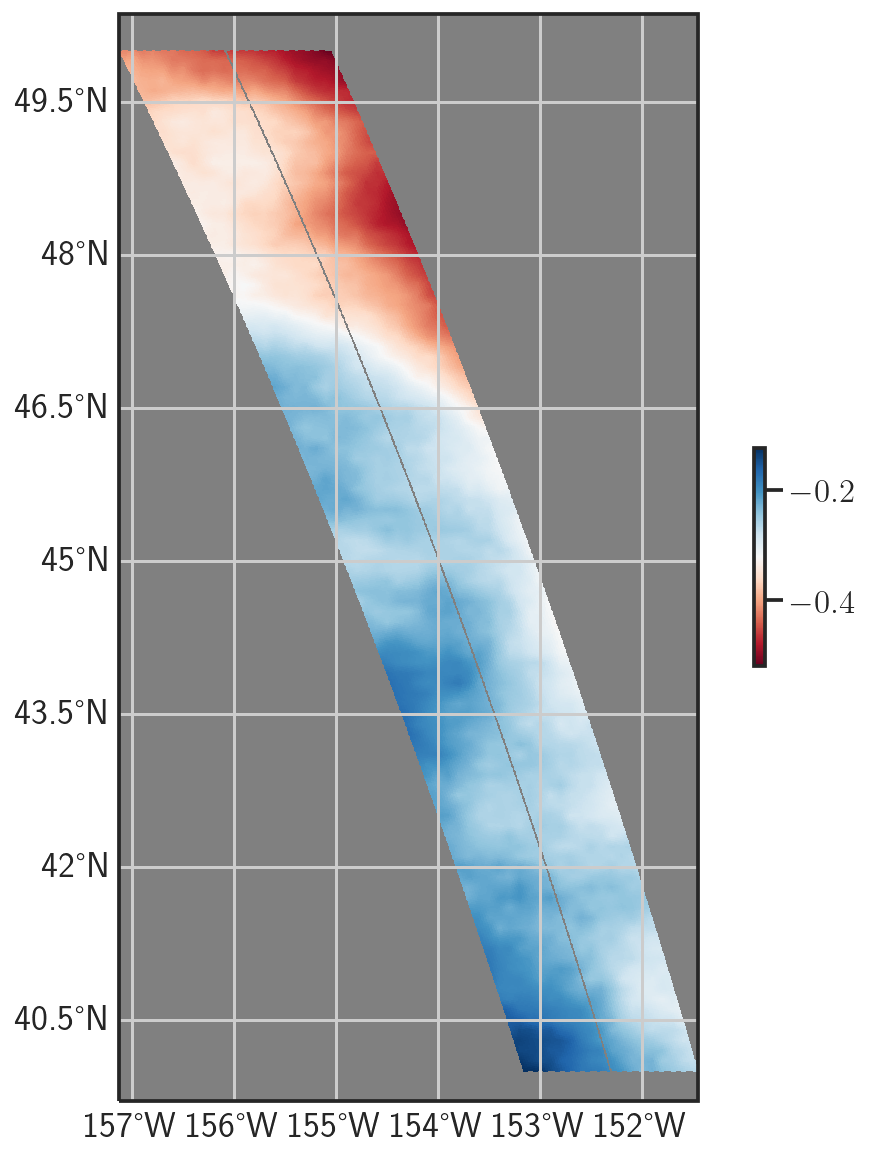

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
p = ds_cut.simulated_true_ssh_karin.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu',add_colorbar=False
)

gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
# ax.set_extent([-160,-80,-75,-45])
    # ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
    # plt.tight_layout()
cbar = fig.colorbar(p,cmap='RdBu',shrink=0.2)
plt.show()

In [707]:
da = ds.ssh_karin
dx = ((dx * u.m).cgs).value
dy = ((dy * u.m).cgs).value

omega = 7.2921e-5 / u.s
detadx, detady = np.gradient(da, dx, dy, axis=(1, 0))
ug = -(c.g0.cgs / (2 * omega * np.sin(da.latitude * np.pi / 180))) * detady

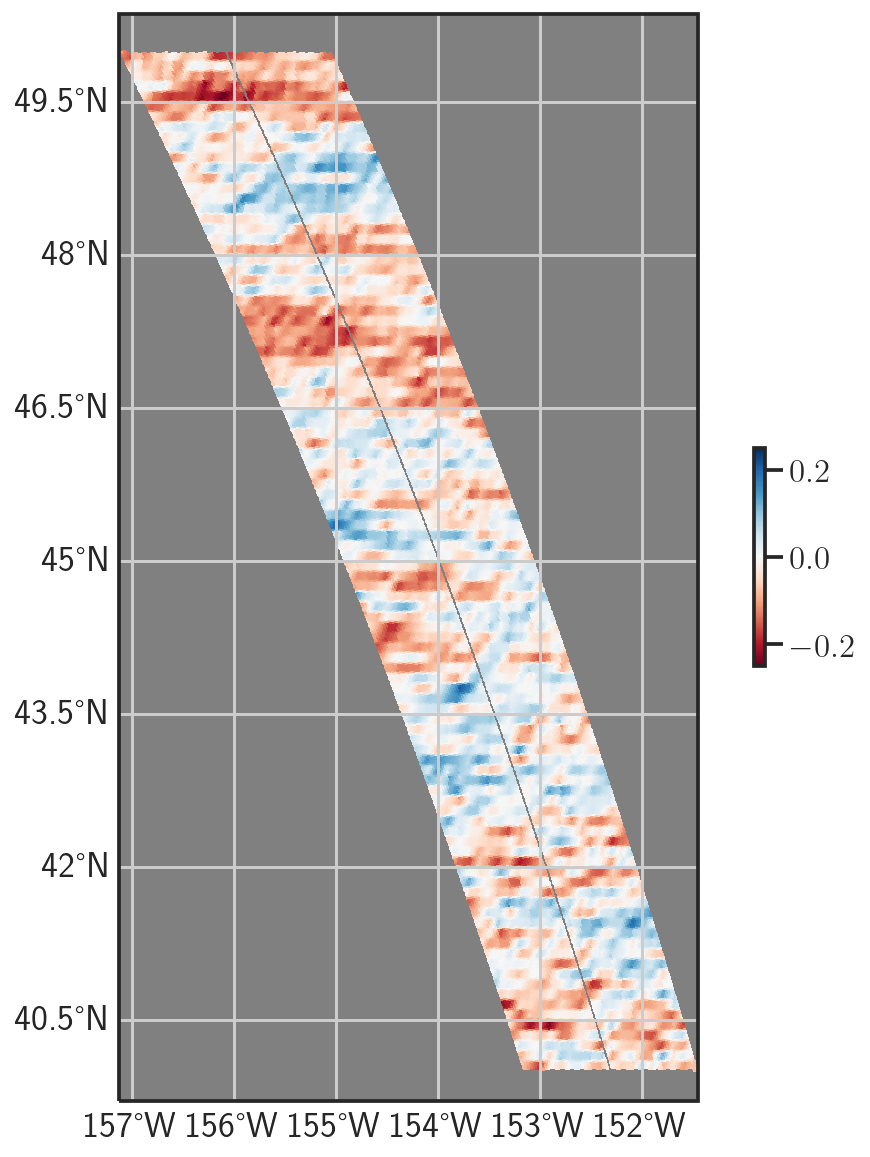

In [706]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(),facecolor='gray')
p = ds_rot.u.plot(x="longitude",y="latitude",
    subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),cmap='RdBu',add_colorbar=False
)

gl = p.axes.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right=False
# ax.set_extent([-160,-80,-75,-45])
    # ax.streamplot(ds_ssh_true_cut_vels_rot.longitude.values,ds_ssh_true_cut_vels_rot.latitude.values,ds_ssh_true_cut_vels_rot.u.values,ds_ssh_true_cut_vels_rot.v.values,transform=ccrs.PlateCarree(),linewidth=200,density=10)
    # plt.tight_layout()
cbar = fig.colorbar(p,cmap='RdBu',shrink=0.2)
plt.show()

In [ ]:
interp_func = interpolate.interp2d(swot_ds_test_rot.num_pixels[()],swot_ds_test_rot.num_lines[()],swot_ds_test_rot.u[()])

In [ ]:
interp_u = interp_func(swot_ds_test_rot.num_pixels[()],swot_ds_test_rot.num_lines[()])

In [711]:
x = np.arange(0, ds.ssh_karin[()].shape[1])
y = np.arange(0, ds.ssh_karin[()].shape[0])
#mask invalid values
masked_u = np.ma.masked_invalid(ds.ssh_karin[()])
xx, yy = np.meshgrid(x, y)
#get only the valid values
x1 = xx[~masked_u.mask]
y1 = yy[~masked_u.mask]
newarr = masked_u[~masked_u.mask]

GD1 = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')

top_nanmask = ~np.any(np.isnan(GD1), axis=1)

GD1 = GD1[(top_nanmask)]
xx = xx[(top_nanmask)]
yy = yy[(top_nanmask)]

In [767]:
def print_factors(x):
   print("The factors of",x,"are:")
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)

print_factors(newarr.shape[0])

The factors of 467309 are:
1
313
1493
467309


In [771]:
newarr_2d = newarr.reshape((1493,313))
x1_2d = x1.reshape((1493,313))
y1_2d = y1.reshape((1493,313))

In [772]:
plt.pcolormesh(x1,y1,newarr_2d)

: 

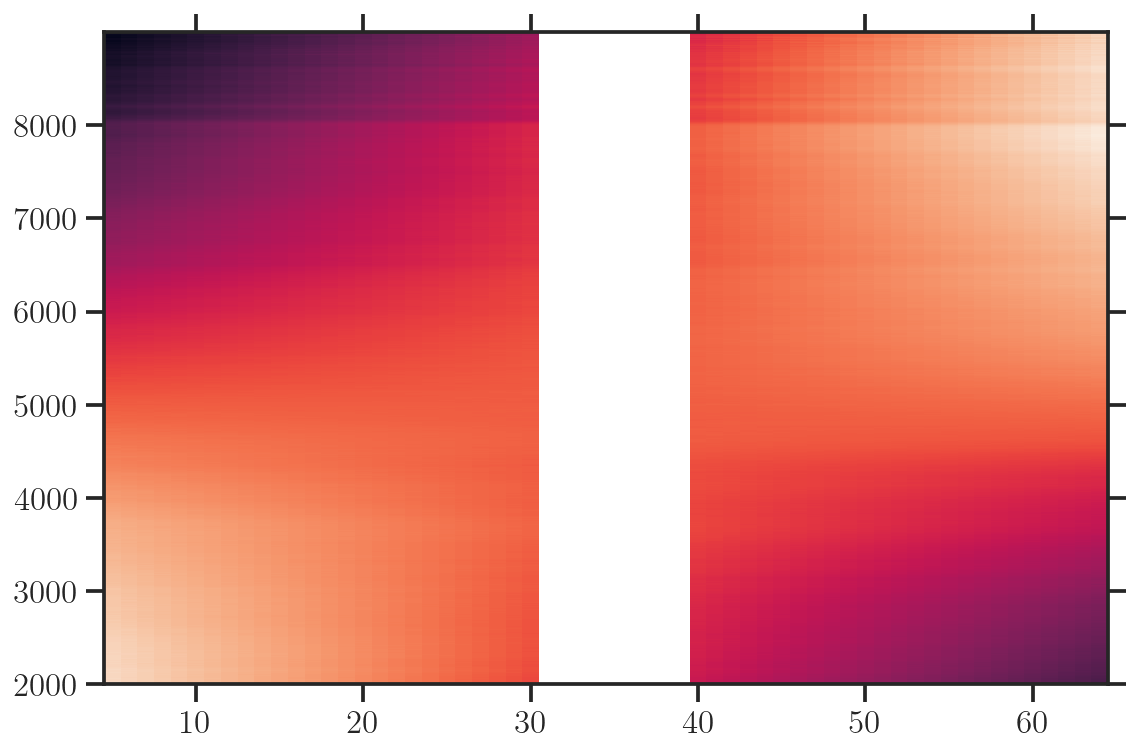

In [741]:
plt.pcolormesh(ds.num_pixels[()][5:65], ds.num_lines[()][2000:9000],ds.ssh_karin[()][2000:9000,5:65])

In [699]:
l1=1e3
l2=1e2
l=1e3
zero_tmp = np.zeros(np.shape(GD1))
one_tmp = np.ones(np.shape(GD1)) / (l*dx)
r_tmp = np.abs(np.sqrt((xx*dx)**2 + (yy*dx)**2))
tophat = np.where(r_tmp < (l*dx/2), one_tmp, zero_tmp)
ul_test = convolve(GD1, tophat, mode='same')


In [701]:
ds_rot["ul"] = ds_rot["u"]

ds_rot.ul.data = ul_test
ds_rot.ul.attrs["long_name"] = "tophat filtered u"
ds_rot.ul.attrs["units"] = "cm/s"

ValueError: replacement data must match the Variable's shape. replacement data has shape (555, 71); Variable has shape (594, 71)

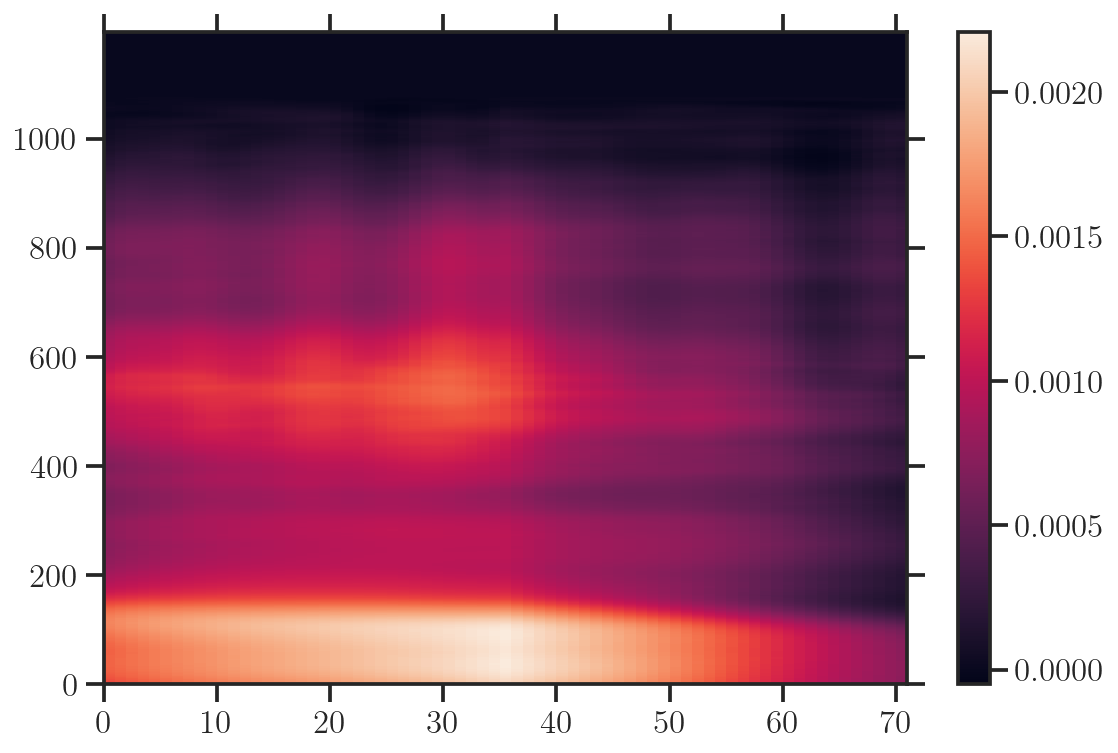

In [673]:
plt.pcolormesh(ul_test)
plt.colorbar()

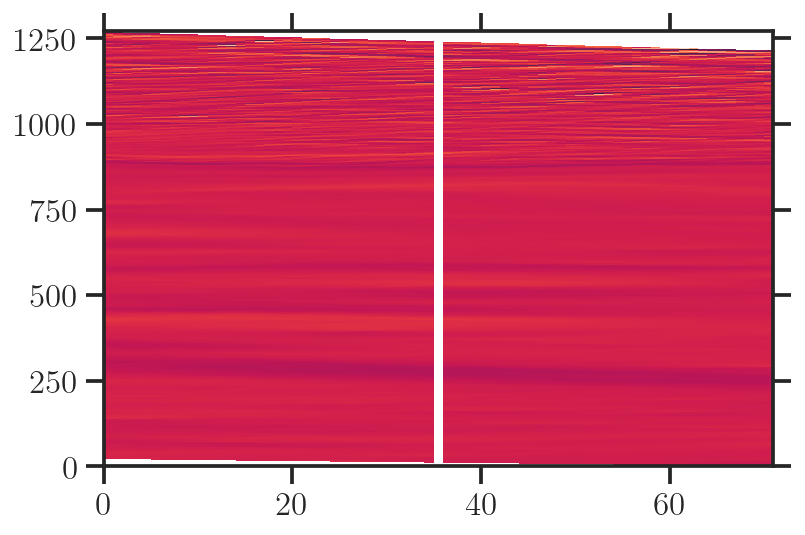

In [ ]:
plt.pcolormesh(swot_ds_test_rot.u[()])

In [ ]:
swot_u_tophat_blur = uniform_filter(df_nonan, size=(1e1,1e1))
swot_u_gaussian_blur = gaussian_filter(df_nonan, sigma=1)

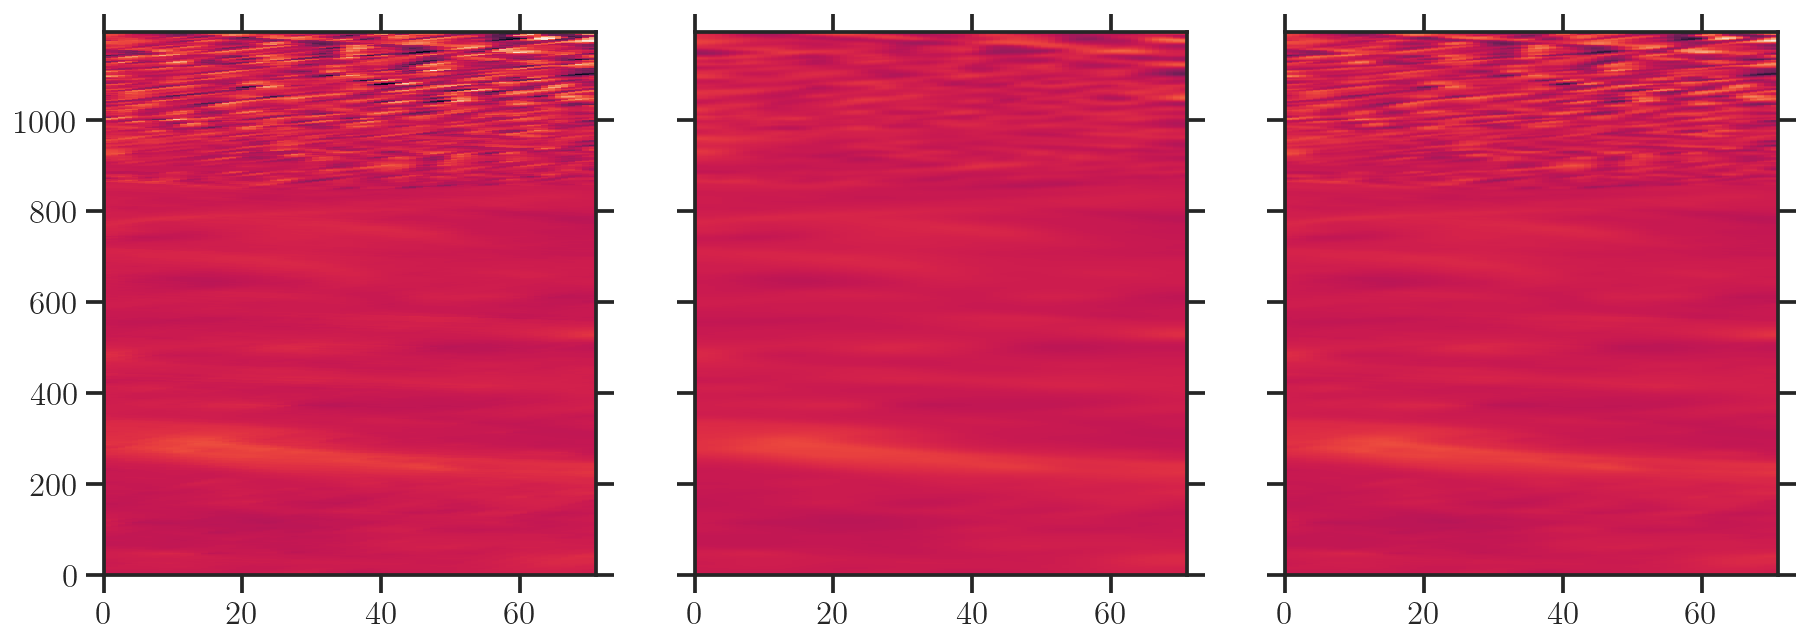

In [ ]:
fig, axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,5))
axs[0].pcolormesh(df_nonan,vmin=-5,vmax=5)
axs[1].pcolormesh(swot_u_tophat_blur,vmin=-5,vmax=5)
axs[2].pcolormesh(swot_u_gaussian_blur,vmin=-5,vmax=5)

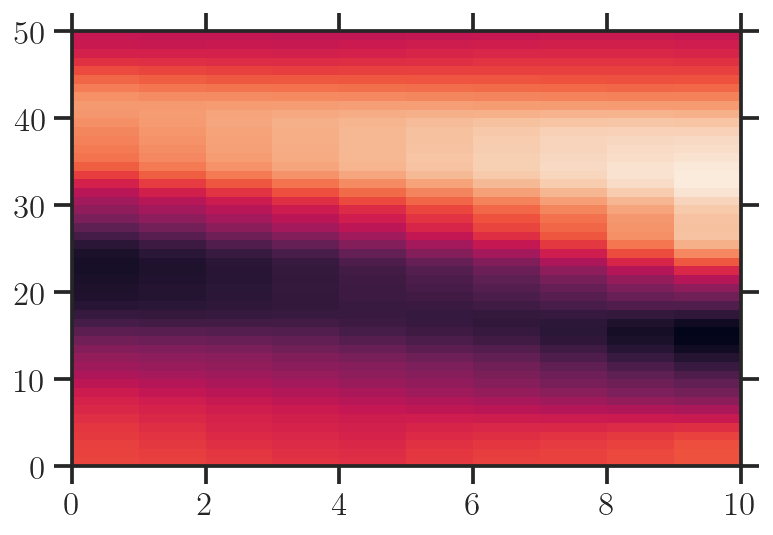

In [ ]:
plt.pcolormesh(swot_u_tophat_blur)

In [ ]:
import parallel_cg_swot
if 'parallel_cg_swot' not in sys.modules:
    import parallel_cg_swot            # import module on first run 
else:                      
    import parallel_cg_swot      
    importlib.reload(parallel_cg_swot)

In [ ]:
uvals = ((swot_ds_test_rot.u.values * (u.cm / u.s)).si).value
vvals = ((swot_ds_test_rot.v.values * (u.cm / u.s)).si).value
wvals = ((swot_ds_test_rot.w.values * (1 / u.s)).si).value

In [ ]:
filename_swot_test = '/Users/cassswagner/Library/CloudStorage/OneDrive-OregonStateUniversity/oceans-research/swot_sf_analysis/data/acc_data/SWOT_L2_LR_SSH_Expert_001_002_20111113T005126_20111113T014253_DG10_01.nc'

test_gauss = parallel_cg_swot.gauss_sfs([1e1,filename_swot_test])

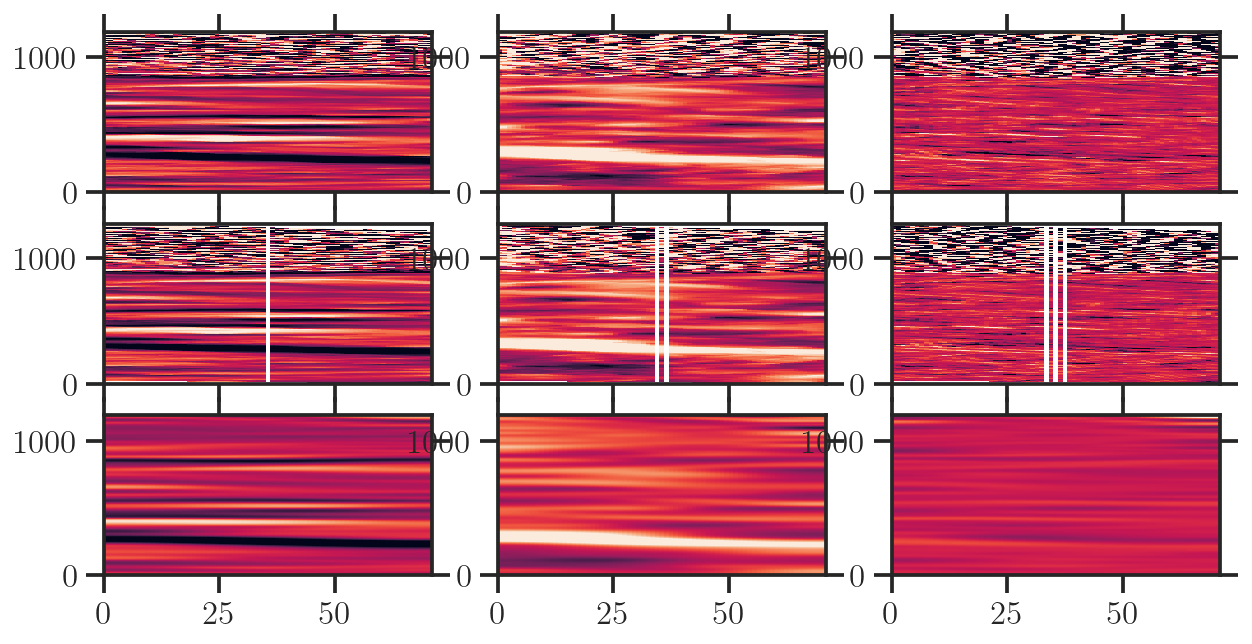

In [ ]:
fig, axs = plt.subplots(3,3,sharex=True,figsize=(10,5))
axs[0,0].pcolormesh(test_gauss[1],vmin=-5e-3,vmax=5e-3)
axs[0,1].pcolormesh(test_gauss[2],vmin=-5e-3,vmax=5e-3)
axs[0,2].pcolormesh(test_gauss[3],vmin=-1e-6,vmax=1e-6)

axs[1,0].pcolormesh(uvals,vmin=-5e-3,vmax=5e-3)
axs[1,1].pcolormesh(vvals,vmin=-5e-3,vmax=5e-3)
axs[1,2].pcolormesh(wvals,vmin=-1e-6,vmax=1e-6)

axs[2,0].pcolormesh(test_gauss[4],vmin=-5e-3,vmax=5e-3)
axs[2,1].pcolormesh(test_gauss[5],vmin=-5e-3,vmax=5e-3)
axs[2,2].pcolormesh(test_gauss[6],vmin=-1e-6,vmax=1e-6)

In [ ]:
test_gauss[0]

SFS_energy_flux  SFS_enstrophy_flux  \
0     3.738253e-14       -4.295755e-22   

                                            filename  sigma  
0  SWOT_L2_LR_SSH_Expert_001_002_20111113T005126_...   10.0

In [ ]:
sum(np.isnan(test_gauss[3]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [ ]:
np.shape(test_gauss[3])

(1193, 71)